# Inerpretation-Net

## Specification of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'function_family': {
        'maximum_depth': 3,
        'beta': 1,
        'decision_sparsity': -1,
        'fully_grown': True,    
        'dt_type': 'SDT', 
    },
    'data': {
        'number_of_variables': 2, 
        'num_classes': 2,
        'categorical_indices': [],
        
        'use_distribution_list': True,
        'random_parameters_distribution': True, 
        'max_distributions_per_class': 1, # None; 0; int >= 1  
        'exclude_linearly_seperable': True,
        'data_generation_filtering': False,
        'fixed_class_probability': False,
        'balanced_data': True,
        'weighted_data_generation': False,
        'shift_distrib': False,
        
        'dt_type_train': 'vanilla', # (None, 'vanilla', 'SDT')
        'maximum_depth_train': 3, #None or int
        'decision_sparsity_train': 1, #None or int
        
        'function_generation_type': 'distribution',
        'distrib_by_feature': True,
        'distribution_list': ['uniform', 'normal', 'gamma', 'beta', 'poisson'],
        'distribution_list_eval': ['uniform', 'normal', 'gamma', 'beta', 'poisson'],
        
        'objective': 'classification',
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform',    
                
        'lambda_dataset_size': 5000, #number of samples per function
        'number_of_generated_datasets': 10000,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', 
        
        'data_noise': 0, 
        
        'distrib_param_max': 5,
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-3,
        'restore_best_weights': True,
        'patience_lambda': 50,
        
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [128],
        'use_batchnorm_lambda': False,
        
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', 
        
        'number_of_lambda_weights': None,
        
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 10000,
    },     
    
    'i_net': {
        'dense_layers': [2048, 1024],
        
        'dropout': [0.3, 0.3],

        'hidden_activation': 'swish',

        'optimizer': 'adam', 
        
        'learning_rate': 0.001,
        
        'separate_weight_bias': False,
        
        'convolution_layers': None,
        'lstm_layers': None,        
        'additional_hidden': False,
        
        'loss': 'binary_crossentropy', 
        'metrics': ['binary_accuracy'], 
        
        'epochs': 500, 
        'early_stopping': True,
        'batch_size': 256,

        'interpretation_dataset_size': 10000,
                
        'test_size': 1000,
        'evaluate_distribution': True,
        'force_evaluate_real_world': False,
        
        'function_representation_type': 1, 
        'normalize_lambda_nets': False,

        'optimize_decision_function': True, 
        'function_value_loss': True, 
                      
        'data_reshape_version': None, 
        
        'resampling_strategy': None,
        'resampling_threshold': 0.2,
        
        'nas': False,
        'nas_type': 'SEQUENTIAL',
        'nas_trials': 60,
        'nas_optimizer': 'greedy'
    },    
    
    'evaluation': {   
        
        'number_of_random_evaluations_per_distribution': 10,
        'random_evaluation_dataset_size_per_distribution': 10_000, 
        'optimize_sampling': True,
            
        'random_evaluation_dataset_size': 500, 
        'random_evaluation_dataset_distribution': 'uniform', 
        
        'per_network_optimization_dataset_size': 5000,

        #'sklearn_dt_benchmark': False,
        #'sdt_benchmark': False,
        
        'different_eval_data': False,
        
        'eval_data_description': {
            ######### data #########
            'eval_data_function_generation_type': 'make_classification',
            'eval_data_lambda_dataset_size': 5000, #number of samples per function
            'eval_data_noise_injected_level': 0, 
            'eval_data_noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'     
            ######### lambda_net #########
            'eval_data_number_of_trained_lambda_nets': 100,
            ######### i_net #########
            'eval_data_interpretation_dataset_size': 100,
        }
        
    },    
    
    'computation':{
        'load_model': False,
        'n_jobs': 35,
        'use_gpu': False,
        'gpu_numbers': '2',
        'RANDOM_SEED': 42,   
        'verbosity': 0
    }
}

### Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

from itertools import product       
from tqdm.notebook import tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import shutil

from copy import deepcopy
import math
import random 


import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score, log_loss
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

#import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import tensorflow.keras.backend as K
from livelossplot import PlotLossesKerasTF
#from keras_tqdm import TQDMNotebookCallback

from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import Image
from IPython.display import display, Math, Latex, clear_output

from prettytable import PrettyTable

from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import xgboost as xgb



In [4]:
tf.__version__

'2.8.0'

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################

config['i_net']['data_reshape_version'] = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
config['function_family']['decision_sparsity'] = config['function_family']['decision_sparsity'] if config['function_family']['decision_sparsity'] != -1 else config['data']['number_of_variables'] 

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' if use_gpu else ''

#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/local/cuda-10.1'

#os.environ['XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda-11.4' if use_gpu else ''#-10.1' #--xla_gpu_cuda_data_dir=/usr/local/cuda, 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2 ,--tf_xla_enable_xla_devices' if use_gpu else ''#'--tf_xla_auto_jit=2' #, --tf_xla_enable_xla_devices


sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)
np.set_printoptions(suppress=True)



In [6]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [7]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
from utilities.DecisionTree_BASIC import *

#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(config)
config['function_family']['basic_function_representation_length'] = get_number_of_function_parameters(dt_type, maximum_depth, number_of_variables, num_classes)
config['function_family']['function_representation_length'] = ( 
       #((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes  if function_representation_type == 1 and dt_type == 'SDT'
       (2 ** maximum_depth - 1) * (number_of_variables + 1) + (2 ** maximum_depth) * num_classes if function_representation_type == 1 and dt_type == 'SDT'
  else (2 ** maximum_depth - 1) * decision_sparsity + (2 ** maximum_depth - 1) + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) * num_classes if function_representation_type == 2 and dt_type == 'SDT'
  else ((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth)  if function_representation_type == 1 and dt_type == 'vanilla'
  else (2 ** maximum_depth - 1) * decision_sparsity + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) if function_representation_type == 2 and dt_type == 'vanilla'
  else ((2 ** maximum_depth - 1) * number_of_variables * 2) + (2 ** maximum_depth)  if function_representation_type >= 3 and dt_type == 'vanilla'
  else ((2 ** maximum_depth - 1) * number_of_variables * 2) + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes if function_representation_type >= 3 and dt_type == 'SDT'
  else None
                                                            )


if distrib_by_feature:
    config['evaluation']['random_evaluation_dataset_distribution'] = config['data']['distribution_list_eval']
    config['data']['distribution_list'] = [config['data']['distribution_list']]
    config['data']['distribution_list_eval'] = [config['data']['distribution_list_eval']]
  
    

#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)
#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='interpretation_net'))

create_folders_inet(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)  

In [8]:
print(path_identifier_interpretation_net)

print(path_identifier_lambda_net_data)


lNetSize5000_numLNets10000_var2_class2_distribution_xMax1_xMin0_xDistuniform_dNoise0_randParamDist_maxDistClass1_distribParamMax5_randClassProb_exLinSepun-no-ga-be-po_depth3_beta1_decisionSpars1_vanilla_fullyGrown/128_e1000ES0.001_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42/inet_dense2048-1024_drop0.3-0.3e500b256_adam_funcRep1_reshapeNone
lNetSize5000_numLNets10000_var2_class2_distribution_xMax1_xMin0_xDistuniform_dNoise0_randParamDist_maxDistClass1_distribParamMax5_randClassProb_exLinSepun-no-ga-be-po_depth3_beta1_decisionSpars1_vanilla_fullyGrown/128_e1000ES0.001_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42


In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [10]:
#%load_ext autoreload
#%autoreload 2

In [11]:
def load_lambda_nets(config, no_noise=False, n_jobs=1):
    
    #def generate_lambda_net()
    
    #if psutil.virtual_memory().percent > 80:
        #raise SystemExit("Out of RAM!")
    
    if no_noise==True:
        config['data']['noise_injected_level'] = 0
    path_dict = generate_paths(config, path_type='interpretation_net')        
        
    directory = './data/weights/' + 'weights_' + path_dict['path_identifier_lambda_net_data'] + '/'
    path_network_parameters = directory + 'weights' + '.txt'
    
    
    #path_X_data = directory + 'X_test_lambda.txt'
    #path_y_data = directory + 'y_test_lambda.txt'
    
    if True:
        path_X_data = './data/saved_function_lists/X_data_' + path_dict['path_identifier_function_data'] + '.pkl'
        with open(path_X_data, 'rb') as f:
            X_data_list = pickle.load(f)

        path_y_data = './data/saved_function_lists/y_data_' + path_dict['path_identifier_function_data'] + '.pkl'
        with open(path_y_data, 'rb') as f:
            y_data_list = pickle.load(f)        
            
    path_distribution_parameters = directory + '/' + 'distribution_parameters' + '.txt'
    
    network_parameters = pd.read_csv(path_network_parameters, sep=",", header=None)
    network_parameters = network_parameters.sort_values(by=0)
    
    try:
        distribution_parameters = pd.read_csv(path_distribution_parameters, sep=",", header=None)
        distribution_parameters = distribution_parameters.sort_values(by=0)
    except:
        distribution_parameters = pd.DataFrame([None] * network_parameters.shape[0])
    
    #if no_noise == False:
    #    network_parameters = network_parameters.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
    #    distribution_parameters = distribution_parameters.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
        
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky

    lambda_nets = parallel(delayed(LambdaNet)(network_parameters_row, 
                                              distribution_parameters_row,
                                              #X_test_lambda_row, 
                                              #y_test_lambda_row, 
                                              X_test_network[1].values,
                                              y_test_network[1].values,
                                              config) for X_test_network, y_test_network, network_parameters_row, distribution_parameters_row in zip(X_data_list[:config['i_net']['interpretation_dataset_size']], 
                                                                                                                                                     y_data_list[:config['i_net']['interpretation_dataset_size']], 
                                                                                                                                                     network_parameters.values[:config['i_net']['interpretation_dataset_size']], 
                                                                                                                                                     distribution_parameters.values[:config['i_net']['interpretation_dataset_size']]))        
    del parallel
    
    base_model = generate_base_model(config)  
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [12]:
#LOAD DATA
if different_eval_data:
    config_train = deepcopy(config)
    config_eval = deepcopy(config)
    
    config_eval['data']['function_generation_type'] = config['evaluation']['eval_data_description']['eval_data_function_generation_type']
    config_eval['data']['lambda_dataset_size'] = config['evaluation']['eval_data_description']['eval_data_lambda_dataset_size']
    config_eval['data']['noise_injected_level'] = config['evaluation']['eval_data_description']['eval_data_noise_injected_level']
    config_eval['data']['noise_injected_type'] = config['evaluation']['eval_data_description']['eval_data_noise_injected_type'] 
    config_eval['lambda_net']['number_of_trained_lambda_nets'] = config['evaluation']['eval_data_description']['eval_data_number_of_trained_lambda_nets']   
    config_eval['i_net']['interpretation_dataset_size'] = config['evaluation']['eval_data_description']['eval_data_interpretation_dataset_size']   
    

    lambda_net_dataset_train = load_lambda_nets(config_train, n_jobs=n_jobs)
    lambda_net_dataset_eval = load_lambda_nets(config_eval, n_jobs=n_jobs)

    if test_size > 0 and not evaluate_distribution:
        lambda_net_dataset_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset_eval, test_split=test_size)   
    else:
        lambda_net_dataset_test = None
        lambda_net_dataset_valid = lambda_net_dataset_eval
        
else:
    lambda_net_dataset = load_lambda_nets(config, n_jobs=n_jobs)

    if test_size > 0 and not evaluate_distribution:
        lambda_net_dataset_train_with_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
        lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset_train_with_valid, test_split=0.1)    
    else:
        lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset, test_split=0.1)    
        lambda_net_dataset_test = None

[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done  58 tasks      | elapsed:   24.6s
[Parallel(n_jobs=35)]: Done 226 tasks      | elapsed:   24.9s
[Parallel(n_jobs=35)]: Done 1366 tasks      | elapsed:   25.8s
[Parallel(n_jobs=35)]: Done 3670 tasks      | elapsed:   27.3s
[Parallel(n_jobs=35)]: Done 6486 tasks      | elapsed:   29.1s
[Parallel(n_jobs=35)]: Done 9723 tasks      | elapsed:   31.2s
[Parallel(n_jobs=35)]: Done 9931 out of 10000 | elapsed:   31.3s remaining:    0.2s
[Parallel(n_jobs=35)]: Done 10000 out of 10000 | elapsed:   31.3s finished


### Data Inspection

In [13]:
print(lambda_net_dataset_train.shape)
print(lambda_net_dataset_valid.shape)
if test_size > 0 and not evaluate_distribution:
    print(lambda_net_dataset_test.shape)

(9000, 552)
(1000, 552)


In [14]:
lambda_net_dataset_valid.as_pandas(config).head()

,index,seed,f0v0,f0v1,f1v0,f1v1,f2v0,f2v1,f3v0,f3v1,f4v0,f4v1,f5v0,f5v1,f6v0,f6v1,b0,b1,b2,b3,b4,b5,b6,lp0c0,lp0c1,lp1c0,lp1c1,lp2c0,lp2c1,lp3c0,lp3c1,lp4c0,lp4c1,lp5c0,lp5c1,lp6c0,lp6c1,lp7c0,lp7c1,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,...,wb_413,wb_414,wb_415,wb_416,wb_417,wb_418,wb_419,wb_420,wb_421,wb_422,wb_423,wb_424,wb_425,wb_426,wb_427,wb_428,wb_429,wb_430,wb_431,wb_432,wb_433,wb_434,wb_435,wb_436,wb_437,wb_438,wb_439,wb_440,wb_441,wb_442,wb_443,wb_444,wb_445,wb_446,wb_447,wb_448,wb_449,wb_450,wb_451,wb_452,wb_453,wb_454,wb_455,wb_456,wb_457,wb_458,wb_459,wb_460,wb_461,wb_462,wb_463,wb_464,wb_465,wb_466,wb_467,wb_468,wb_469,wb_470,wb_471,wb_472,wb_473,wb_474,wb_475,wb_476,wb_477,wb_478,wb_479,wb_480,wb_481,wb_482,wb_483,wb_484,wb_485,wb_486,wb_487,wb_488,wb_489,wb_490,wb_491,wb_492,wb_493,wb_494,wb_495,wb_496,wb_497,wb_498,wb_499,wb_500,wb_501,wb_502,wb_503,wb_504,wb_505,wb_506,wb_507,wb_508,wb_509,wb_510,wb_511,wb_512
6252,6252.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.036,-0.099,-0.018,-0.046,0.217,0.164,0.031,-0.061,-0.014,-0.122,-0.182,0.006,-0.089,-0.046,-0.056,0.115,-0.037,-0.164,-0.342,-0.000,0.183,-0.050,-0.195,0.158,-0.366,0.029,0.073,-0.034,-0.063,-0.180,0.123,-0.147,-0.320,-0.041,0.107,-0.167,-0.010,0.115,-0.214,0.245,0.158,-0.045,-0.120,0.124,-0.207,-0.008,0.007,0.125,-0.066,-0.088,0.123,0.045,0.034,0.261,-0.214,0.077,0.073,-0.150,-0.097,0.256,0.231,...,0.123,-0.048,0.109,0.360,-0.167,-0.026,-0.112,2.113,0.818,0.043,0.127,1.147,0.008,-0.059,0.135,-0.152,-0.088,-0.069,1.365,-0.179,-0.089,1.502,1.892,1.619,0.170,0.076,-0.167,0.077,0.122,-0.251,0.116,0.136,0.056,1.478,-0.150,-0.208,0.127,-0.091,0.425,-0.015,0.025,-0.032,-0.005,0.117,-0.047,-0.083,1.580,0.398,1.000,-0.136,-0.145,-0.008,-0.014,0.221,0.051,-0.177,-0.176,0.704,-0.002,-0.023,1.769,-0.196,-0.197,-0.100,-0.041,-0.175,0.136,1.412,0.201,-0.015,-0.158,-0.053,1.260,-0.153,-0.105,0.100,0.041,1.706,0.022,1.093,1.382,-0.209,-0.101,0.201,0.730,0.084,-0.041,-0.025,0.114,-0.180,-0.066,0.074,0.138,1.132,-0.096,-0.275,-0.150,0.086,0.052,0.003
4684,4684.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.036,-0.099,-0.013,-0.055,0.193,0.193,0.044,-0.061,0.041,-0.122,-0.176,0.036,-0.089,-0.099,-0.056,0.091,-0.023,-0.168,-0.126,0.014,0.220,-0.050,-0.195,0.172,-0.107,0.162,0.070,-0.034,-0.106,-0.170,0.209,-0.147,-0.090,-0.052,0.194,-0.167,0.005,0.142,-0.214,0.199,0.160,-0.045,-0.120,0.071,-0.207,-0.008,0.043,0.079,-0.130,-0.161,-0.076,0.026,0.041,0.204,-0.214,0.145,0.029,-0.150,-0.158,0.206,0.177,...,0.146,-0.157,0.109,0.168,-0.103,-0.089,-0.112,0.189,0.074,0.043,-0.024,0.149,0.008,-0.059,0.196,-0.152,-0.088,-0.106,0.163,-0.102,-0.010,0.093,0.118,0.039,0.191,0.076,-0.207,0.157,0.122,-0.161,0.143,0.164,0.056,0.085,-0.058,-0.149,0.141,-0.066,0.113,-0.032,0.058,-0.032,-0.019,0.129,-0.084,-0.096,0.099,-0.058,0.074,-0.143,-0.155,-0.008,0.033,0.136,0.051,-0.177,-0.128,0.150,-0.012,-0.023,0.025,-0.119,-0.109,-0.100,-0.131,-0.175,0.178,0.031,0.201,0.036,-0.158,-0.062,0.153,-0.156,-0.015,0.141,0.100,0.023,0.035,0.151,0.130,-0.189,-0.137,0.201,0.060,0.103,-0.077,-0.032,0.114,-0.180,-0.095,0.074,0.199,-0.024,-0.096,-0.193,-0.185,0.060,0.053,0.001
1731,1731.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0

In [15]:
lambda_net_dataset_train.samples_class_0_list_array[1]

In [16]:
lambda_net_dataset_train.distribution_dict_row_array[1]

In [17]:
lambda_net_dataset_train.distribution_dict_list_list[1]

# Interpretation Network Training

In [18]:
#%load_ext autoreload
#%autoreload 2

In [19]:
((X_valid, y_valid), 
 (X_test, y_test),
 
 history,
 loss_function,
 metrics,
 
 model,
 encoder_model) = interpretation_net_training(
                                      lambda_net_dataset_train, 
                                      lambda_net_dataset_valid, 
                                      lambda_net_dataset_test,
                                      config,
                                      #callback_names=plot_losses
                                     )



----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
network_parameters_structure [(2, 128), (128,), (128, 1), (1,)]
Epoch 1/500
36/36 - 12s - loss: 0.6409 - binary_accuracy_inet_decision_function_fv_metric: 0.6400 - val_loss: 0.5664 - val_binary_accuracy_inet_decision_function_fv_metric: 0.7073 - lr: 0.0010 - 12s/epoch - 326ms/step
Epoch 2/500
36/36 - 5s - loss: 0.5068 - binary_accuracy_inet_decision_function_fv_metric: 0.7475 - val_loss: 0.5275 - val_binary_accuracy_inet_decision_function_fv_metric: 0.7399 - lr: 0.0010 - 5s/epoch - 129ms/step
Epoch 3/500
36/36 - 5s - loss: 0.4855 - binary_accuracy_inet_decision_function_fv_metric: 0.7608 - val_loss: 0.4635 - val_binary_accuracy_inet_decision_function_fv_metric: 0.7739 - lr: 0.0010 - 5s/epoch - 126ms/step
Epoch 4/500
36/36 - 4s - loss: 0.4492 - binary_accuracy_inet_decision_function_fv_metric: 0.7900 - val_loss: 0.3909 - val_binary_accuracy_inet_decision_function_f

<Figure size 432x288 with 0 Axes>

## Evaluate I-Net Training Process

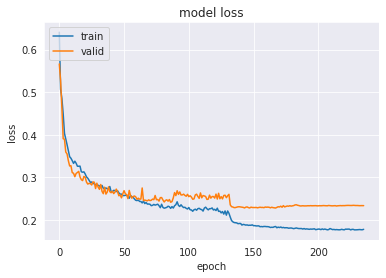

In [20]:
if nas:
    for trial in history: 
        print(trial.summary())
        
    writepath_nas = './results_nas.csv'

    if different_eval_data:
        flat_config = flatten_dict(config_train)
    else:
        flat_config = flatten_dict(config)    

    if not os.path.exists(writepath_nas):
        with open(writepath_nas, 'w+') as text_file:       
            for key in flat_config.keys():
                text_file.write(key)
                text_file.write(';')         

            for hp in history[0].hyperparameters.values.keys():
                text_file.write(hp + ';')    
               
            text_file.write('score')
            
            text_file.write('\n')

    with open(writepath_nas, 'a+') as text_file:  
        for value in flat_config.values():
            text_file.write(str(value))
            text_file.write(';')

        for hp, value in history[0].hyperparameters.values.items():
            text_file.write(str(value) + ';')        

        
        text_file.write(str(history[0].score))
            
        text_file.write('\n')            

        text_file.close()      
        
else:
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')    

In [21]:
if False:
    index = 0
    lambda_net = lambda_net_dataset_train.lambda_net_list[index]
    
    lambda_net_model = network_parameters_to_network(lambda_net.network_parameters, config)
    lambda_net_model_preds = lambda_net_model.predict(lambda_net.X_train_lambda)
    dt_train_data = DecisionTreeClassifier(max_depth=3)
    dt_train_data.fit(lambda_net.X_train_lambda, np.round(lambda_net_model_preds))
    
    random_data = np.random.uniform(0, 1, lambda_net.X_train_lambda.shape)
    lambda_net_model_preds_random = lambda_net_model.predict(random_data)
    dt_random_data = DecisionTreeClassifier(max_depth=3)
    dt_random_data.fit(random_data, np.round(lambda_net_model_preds_random))
    
    plot_decision_area_evaluation(lambda_net.X_train_lambda, 
                                lambda_net.y_train_lambda.flatten(), 
                                lambda_net.X_test_lambda, 
                                lambda_net.y_test_lambda.flatten(),
                                random_data,
                                lambda_net_model_preds_random.flatten(),                                   
                                lambda_net_model,
                                dt_train_data,
                                dt_random_data,
                                dt_random_data,
                                dt_random_data,
                                model.predict(np.array([lambda_net.network_parameters]))[0],
                                np.array([str(i) for i in range(lambda_net.X_train_lambda.shape[1])]),
                                config
                               )

    index = 0
    lambda_net = lambda_net_dataset_valid.lambda_net_list[index]
    
    lambda_net_model = network_parameters_to_network(lambda_net.network_parameters, config)
    lambda_net_model_preds = lambda_net_model.predict(lambda_net.X_train_lambda)
    dt_train_data = DecisionTreeClassifier(max_depth=3)
    dt_train_data.fit(lambda_net.X_train_lambda, np.round(lambda_net_model_preds))
    
    random_data = np.random.uniform(0, 1, lambda_net.X_train_lambda.shape)
    lambda_net_model_preds_random = lambda_net_model.predict(random_data)
    dt_random_data = DecisionTreeClassifier(max_depth=3)
    dt_random_data.fit(random_data, np.round(lambda_net_model_preds_random))
    
    plot_decision_area_evaluation(lambda_net.X_train_lambda, 
                                lambda_net.y_train_lambda.flatten(), 
                                lambda_net.X_test_lambda, 
                                lambda_net.y_test_lambda.flatten(),
                                random_data,
                                lambda_net_model_preds_random.flatten(), 
                                lambda_net_model,
                                dt_train_data,
                                dt_random_data,
                                dt_random_data,
                                dt_random_data,
                                model.predict(np.array([lambda_net.network_parameters]))[0],
                                np.array([str(i) for i in range(lambda_net.X_train_lambda.shape[1])]),
                                config
                               )    

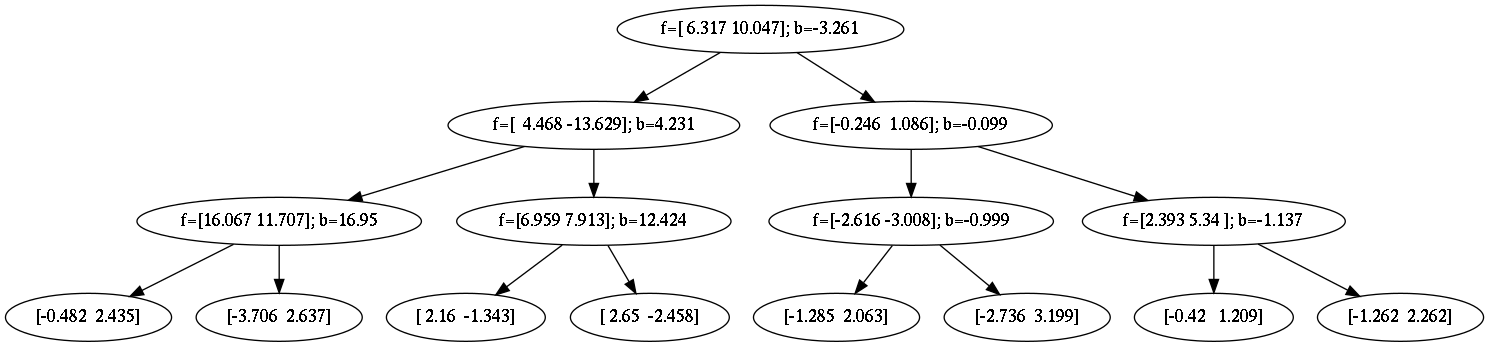

In [22]:
index = 0
if test_size > 0 and not evaluate_distribution:
    network_parameters = np.array([lambda_net_dataset_test.network_parameters_array[index]])
else:
    network_parameters = np.array([lambda_net_dataset_valid.network_parameters_array[index]])
    
if config['i_net']['data_reshape_version'] == 1 or config['i_net']['data_reshape_version'] == 2:
    network_parameters, network_parameters_flat = restructure_data_cnn_lstm(network_parameters, config, subsequences=None)
elif config['i_net']['data_reshape_version'] == 3: #autoencoder
    encoder_model = load_encoder_model(config)
    network_parameters, network_parameters_flat, _ = autoencode_data(network_parameters, config, encoder_model)    
dt_parameters = model.predict(network_parameters)[0]

if config['function_family']['dt_type'] == 'vanilla':
    image, nodes = anytree_decision_tree_from_parameters(dt_parameters, config=config)
else:
    tree = generate_random_decision_tree(config)
    tree.initialize_from_parameter_array(dt_parameters, reshape=True, config=config)
    image = tree.plot_tree()
image

In [23]:
image = None
if not function_value_loss:
    if test_size > 0 and not evaluate_distribution:
        dt_parameters = y_test[index][:-2 ** config['function_family']['maximum_depth'] ]
    else:
        dt_parameters = y_valid[index][:-2 ** config['function_family']['maximum_depth'] ]

    image, nodes = anytree_decision_tree_from_parameters(dt_parameters, config=config)
image

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 513)]        0           []                               
                                                                                                  
 hidden1_2048 (Dense)           (None, 2048)         1052672     ['input[0][0]']                  
                                                                                                  
 activation1_swish (Activation)  (None, 2048)        0           ['hidden1_2048[0][0]']           
                                                                                                  
 dropout1_0.3 (Dropout)         (None, 2048)         0           ['activation1_swish[0][0]']      
                                                                                              

    Normal: This is useful for looking at means and other linear combinations (e.g. regression coefficients) because of the CLT. Related to that is if something is known to arise due to additive effects of many different small causes then the normal may be a reasonable distribution: for example, many biological measures are the result of multiple genes and multiple environmental factors and therefor are often approximately normal.

    Gamma: Right skewed and useful for things with a natural minimum at 0. Commonly used for elapsed times and some financial variables.

    Exponential: special case of the Gamma. It is memoryless and scales easily.

    Chi-squared (𝜒2): special case of the Gamma. Arises as sum of squared normal variables (so used for variances).

    Beta: Defined between 0 and 1 (but could be transformed to be between other values), useful for proportions or other quantities that must be between 0 and 1.

    Binomial: How many "successes" out of a given number of independent trials with same probability of "success".

    Poisson: Common for counts. Nice properties that if the number of events in a period of time or area follows a Poisson, then the number in twice the time or area still follows the Poisson (with twice the mean): this works for adding Poissons or scaling with values other than 2.

    Note that if events occur over time and the time between occurrences follows an exponential then the number that occur in a time period follows a Poisson.

    Negative Binomial: Counts with minimum 0 (or other value depending on which version) and no upper bound. Conceptually it is the number of "failures" before k "successes". The negative binomial is also a mixture of Poisson variables whose means come from a gamma distribution.

    Geometric: special case for negative binomial where it is the number of "failures" before the 1st "success". If you truncate (round down) an exponential variable to make it discrete, the result is geometric.

## Train & Valid Data Evaluation

In [25]:

mean_train_parameters = np.round(np.mean(lambda_net_dataset_train.network_parameters_array, axis=0), 5)
std_train_parameters = np.round(np.std(lambda_net_dataset_train.network_parameters_array, axis=0), 5)

(inet_evaluation_result_dict_train, 
 inet_evaluation_result_dict_mean_train, 
 dt_distilled_list_train,
 distances_dict) = evaluate_interpretation_net_synthetic_data(lambda_net_dataset_train.network_parameters_array, 
                                                               lambda_net_dataset_train.X_test_lambda_array,
                                                               model,
                                                               config,
                                                               identifier='train',
                                                               mean_train_parameters=mean_train_parameters,
                                                               std_train_parameters=std_train_parameters,
                                                               network_parameters_train_array=lambda_net_dataset_train.network_parameters_array)


(inet_evaluation_result_dict_valid, 
 inet_evaluation_result_dict_mean_valid, 
 dt_distilled_list_valid,
 distances_dict) = evaluate_interpretation_net_synthetic_data(lambda_net_dataset_valid.network_parameters_array, 
                                                               lambda_net_dataset_valid.X_test_lambda_array,
                                                               model,
                                                               config,
                                                               identifier='valid',
                                                               mean_train_parameters=mean_train_parameters,
                                                               std_train_parameters=std_train_parameters,
                                                               network_parameters_train_array=lambda_net_dataset_train.network_parameters_array,
                                                               distances_dict=distances_dict)

[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done  32 out of  50 | elapsed:  1.2min remaining:   40.9s
[Parallel(n_jobs=35)]: Done  50 out of  50 | elapsed:  1.4min finished


  0%|          | 0/50 [00:00<?, ?it/s]

[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done  32 out of  50 | elapsed:   18.4s remaining:   10.4s
[Parallel(n_jobs=35)]: Done  50 out of  50 | elapsed:   30.8s finished


  0%|          | 0/50 [00:00<?, ?it/s]

## Test Data Evaluation (+ Distribution Evaluation)

In [26]:
%load_ext autoreload
%autoreload 2
#set_loky_pickler('pickle')

In [27]:
#config['computation']['n_jobs'] = 60
#config['i_net']['test_size'] = 1000

In [28]:
if evaluate_distribution and test_size > 0:
    
    (distances_dict, 
     inet_evaluation_result_dict_test, 
     inet_evaluation_result_dict_complete_by_distribution_test,
     inet_evaluation_result_dict_mean_test,
     inet_evaluation_result_dict_mean_by_distribution_test,
     inet_evaluation_results_test, 
     dt_inet_list_test, 
     dt_distilled_list_test, 
     data_dict_list_test, 
     normalizer_list_list_test,
     test_network_list_distrib,
     model_history_list,
     distribution_parameter_list_list) = distribution_evaluation_interpretation_net_synthetic_data(loss_function, 
                                                                                            metrics,
                                                                                            #model,
                                                                                           config,
                                                                                           distribution_list_evaluation = config['data']['distribution_list_eval'],#['uniform', 'normal', 'gamma', 'exponential', 'beta', 'binomial', 'poisson'],
                                                                                           identifier='test',
                                                                                           lambda_net_parameters_train=lambda_net_dataset_train.network_parameters_array,
                                                                                           mean_train_parameters=mean_train_parameters,
                                                                                           std_train_parameters=std_train_parameters,
                                                                                           distances_dict=distances_dict,
                                                                                           max_distributions_per_class=max_distributions_per_class,#max_distributions_per_class,
                                                                                           flip_percentage=noise_injected_level, #0.1,#
                                                                                           data_noise=data_noise, #0.1,#
                                                                                           random_parameters = random_parameters_distribution, #random_parameters_distribution
                                                                                           verbose=0,
                                                                                           backend='loky',#sequential
                                                                                    )
else:
    (inet_evaluation_result_dict_test, 
     inet_evaluation_result_dict_mean_test, 
     dt_distilled_list_test,
     distances_dict) = evaluate_interpretation_net_synthetic_data(lambda_net_dataset_test.network_parameters_array, 
                                                                   lambda_net_dataset_test.X_test_lambda_array,
                                                                   model,
                                                                   config,
                                                                   identifier='test',
                                                                   mean_train_parameters=mean_train_parameters,
                                                                   std_train_parameters=std_train_parameters,
                                                                   network_parameters_train_array=lambda_net_dataset_train.network_parameters_array,
                                                                   distances_dict=distances_dict)
    
    print_results_synthetic_evaluation(inet_evaluation_result_dict_mean_train, 
                                       inet_evaluation_result_dict_mean_valid, 
                                       inet_evaluation_result_dict_mean_test, 
                                       distances_dict)    

[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done  58 tasks      | elapsed:  3.6min
[Parallel(n_jobs=35)]: Done 218 tasks      | elapsed: 13.5min
[Parallel(n_jobs=35)]: Done 442 tasks      | elapsed: 27.6min
[Parallel(n_jobs=35)]: Done 730 tasks      | elapsed: 42.0min
[Parallel(n_jobs=35)]: Done 1000 out of 1000 | elapsed: 54.3min finished


In [29]:
if evaluate_distribution and test_size > 0:
    #print(distribution_parameter_list_list[0])
    #print(lambda_net_dataset_valid.distribution_dict_list_list[0])

    inet_performance_distrib_evaluation = np.array(inet_evaluation_result_dict_complete_by_distribution_test[list(inet_evaluation_result_dict_complete_by_distribution_test.keys())[0]]['inet_scores']['accuracy'])
    print('I-Net Performance by Network: ', inet_performance_distrib_evaluation)

    mean_random_performance_distrib_evaluation = np.mean(np.array([inet_evaluation_result_dict_complete_by_distribution_test[str(distrib)]['dt_scores']['accuracy'] for distrib in config['data']['distribution_list_eval']]), axis=0)
    print('Distilled Mean Performance by Network: ', mean_random_performance_distrib_evaluation)

    max_random_performance_distrib_evaluation = np.max(np.array([inet_evaluation_result_dict_complete_by_distribution_test[str(distrib)]['dt_scores']['accuracy'] for distrib in config['data']['distribution_list_eval']]), axis=0)
    print('Distilled Max Performance by Network: ', max_random_performance_distrib_evaluation)

    print('Median I-Net:', np.median(inet_evaluation_result_dict_complete_by_distribution_test[list(inet_evaluation_result_dict_complete_by_distribution_test.keys())[0]]['inet_scores']['accuracy']))
    print('Median DT Distilled:', np.median(np.median(np.array([inet_evaluation_result_dict_complete_by_distribution_test[str(distrib)]['dt_scores']['accuracy'] for distrib in config['data']['distribution_list_eval']]), axis=0)))#np.median(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['dt_scores']['accuracy']))

    complete_distribution_evaluation_results = get_complete_distribution_evaluation_results_dataframe(inet_evaluation_result_dict_mean_by_distribution_test)
    display(complete_distribution_evaluation_results.head(20))
    
    network_distances = get_print_network_distances_dataframe(distances_dict)
    display(network_distances.head(20))

I-Net Performance by Network:  [0.718 0.776 1.    ... 0.958 0.948 0.99 ]
Distilled Mean Performance by Network:  [0.87  0.26  1.    ... 0.97  0.84  0.868]
Distilled Max Performance by Network:  [0.87  0.26  1.    ... 0.97  0.84  0.868]
Median I-Net: 0.952
Median DT Distilled: 0.903


,Acc Distilled Train Data,Acc Distilled Data Random,Acc Distilled,Acc I-Net,Soft BC Distilled Train Data,Soft BC Distilled Data Random,Soft BC Distilled,Soft BC I-Net,BC Distilled Train Data,BC Distilled Data Random,BC Distilled,BC I-Net,F1 Score Distilled Train Data,F1 Score Distilled Data Random,F1 Score Distilled,F1 Score I-Net,ROC AUC Score Distilled Train Data,ROC AUC Score Distilled Data Random,ROC AUC Score Distilled,ROC AUC Score I-Net,Runtime Distilled Train Data,Runtime Distilled Data Random,Runtime Distilled,Runtime I-Net
"['uniform', 'normal', 'gamma', 'beta', 'poisson']",0.961,0.964,0.800,0.922,0.604,0.500,0.646,0.605,0.123,0.106,0.512,0.211,0.959,0.963,0.767,0.920,0.970,0.986,0.945,0.967,27.028,27.028,27.028,0.138


,Average Z-Score (Sample to Train Data),Average Distance to Initialization,Average Mean Distance to Train Data,Average Distance to closest Train Data Sample,Average Biggest Distance for Single Neuron,Minimum Biggest Distance for Single Neuron
train,217.278,92.099,143.633,0.000,4.123,0.000
valid,231.446,101.146,149.109,49.145,4.417,1.532
test,226.819,99.136,149.556,33.562,4.322,1.531


In [30]:
#%load_ext autoreload
#%autoreload 2

Index:  278
Feature 1:  Samples 4257 / 743
	 Distribution 1: gamma
		 shape: 1.417
		 scale: 0.128
	 Distribution 2: gamma
		 shape: 3.332
		 scale: 2.923
Feature 2:  Samples 4171 / 829
	 Distribution 1: uniform
		 low: 0.608
		 high: 2.005
	 Distribution 2: uniform
		 low: 0.882
		 high: 4.566
RESHAPE0
Considered Columns:								 0   1
Performance Network:								 0.654
Fidelity DT Sklearn Train Data:							 0.986
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.136
Fidelity DT Sklearn Uniform Data:						 0.136
Fidelity DT Sklearn Normal Data:						 0.136
Fidelity DT I-Net:								 0.992


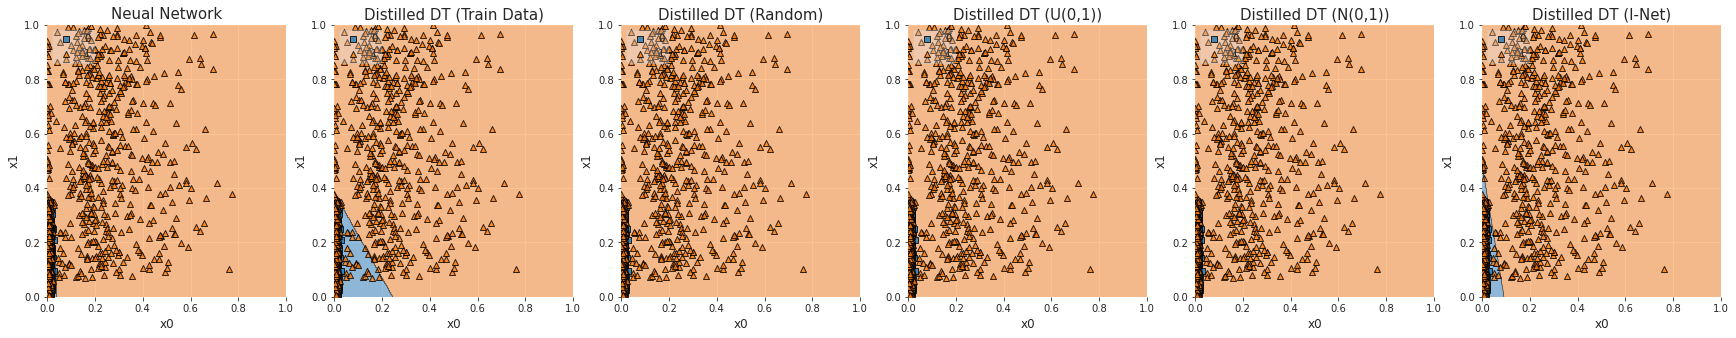

-----------------------------------------------------
Index:  702
Feature 1:  Samples 4088 / 912
	 Distribution 1: gamma
		 shape: 2.274
		 scale: 0.152
	 Distribution 2: gamma
		 shape: 4.777
		 scale: 4.707
Feature 2:  Samples 170 / 4830
	 Distribution 1: poisson
		 lam: 3.496
	 Distribution 2: poisson
		 lam: 3.334
RESHAPE0
Considered Columns:								 0   1
Performance Network:								 0.676
Fidelity DT Sklearn Train Data:							 0.992
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.154
Fidelity DT Sklearn Uniform Data:						 0.154
Fidelity DT Sklearn Normal Data:						 0.154
Fidelity DT I-Net:								 0.998


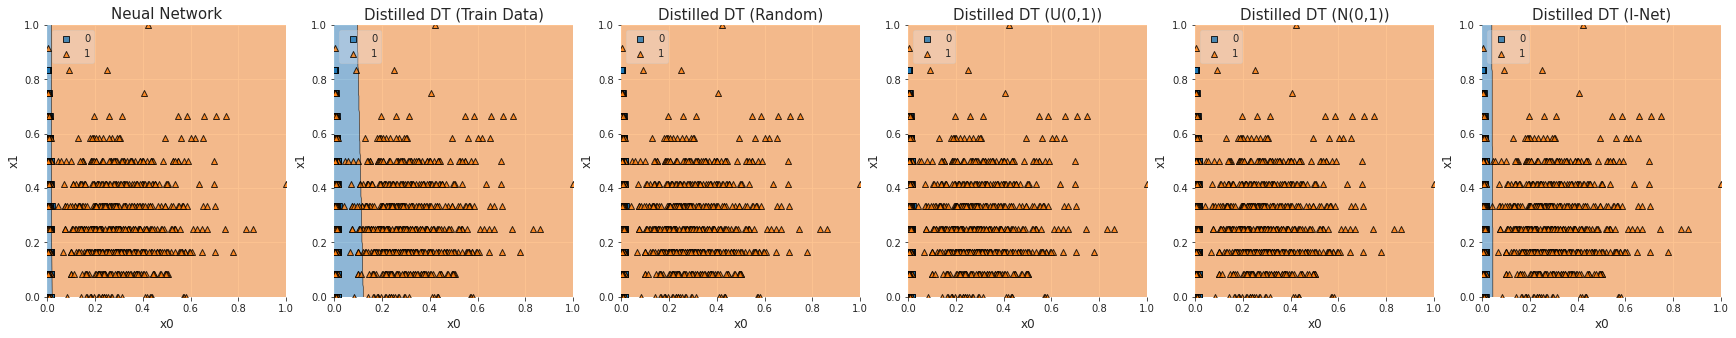

-----------------------------------------------------
Index:  608
Feature 1:  Samples 4750 / 250
	 Distribution 1: uniform
		 low: 0.507
		 high: 3.705
	 Distribution 2: uniform
		 low: 2.215
		 high: 3.587
Feature 2:  Samples 3793 / 1207
	 Distribution 1: uniform
		 low: 3.503
		 high: 3.525
	 Distribution 2: uniform
		 low: 3.22
		 high: 3.707
RESHAPE0
Considered Columns:								 0   1
Performance Network:								 0.722
Fidelity DT Sklearn Train Data:							 0.95
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.196
Fidelity DT Sklearn Uniform Data:						 0.196
Fidelity DT Sklearn Normal Data:						 0.196
Fidelity DT I-Net:								 0.962


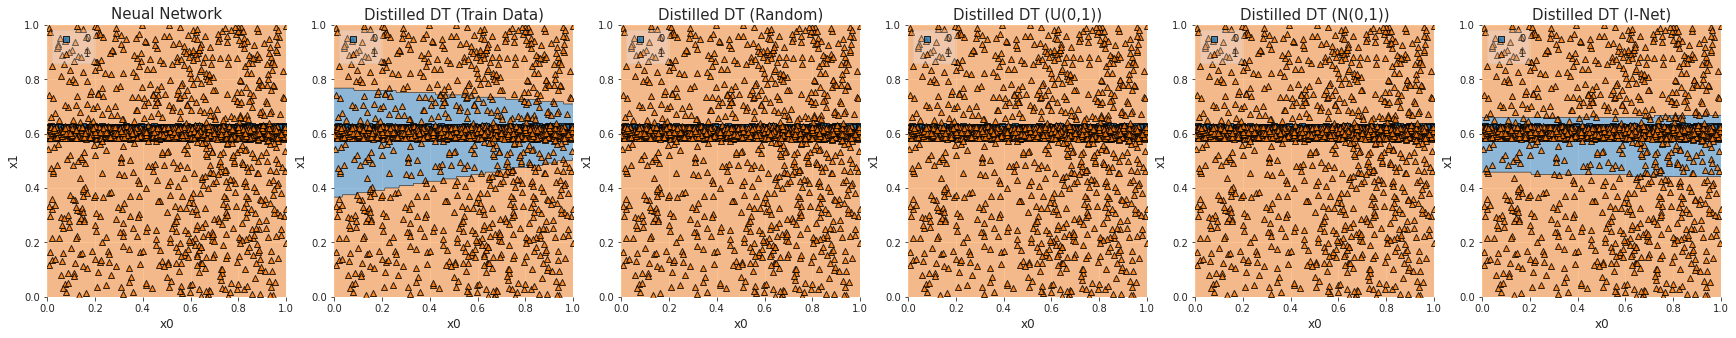

-----------------------------------------------------
Index:  581
Feature 1:  Samples 702 / 4298
	 Distribution 1: normal
		 loc: 3.419
		 scale: 2.527
	 Distribution 2: normal
		 loc: 1.515
		 scale: 0.032
Feature 2:  Samples 4368 / 632
	 Distribution 1: poisson
		 lam: 2.77
	 Distribution 2: poisson
		 lam: 4.648
RESHAPE0
Considered Columns:								 0   1
Performance Network:								 0.65
Fidelity DT Sklearn Train Data:							 0.88
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.196
Fidelity DT Sklearn Uniform Data:						 0.196
Fidelity DT Sklearn Normal Data:						 0.196
Fidelity DT I-Net:								 0.928


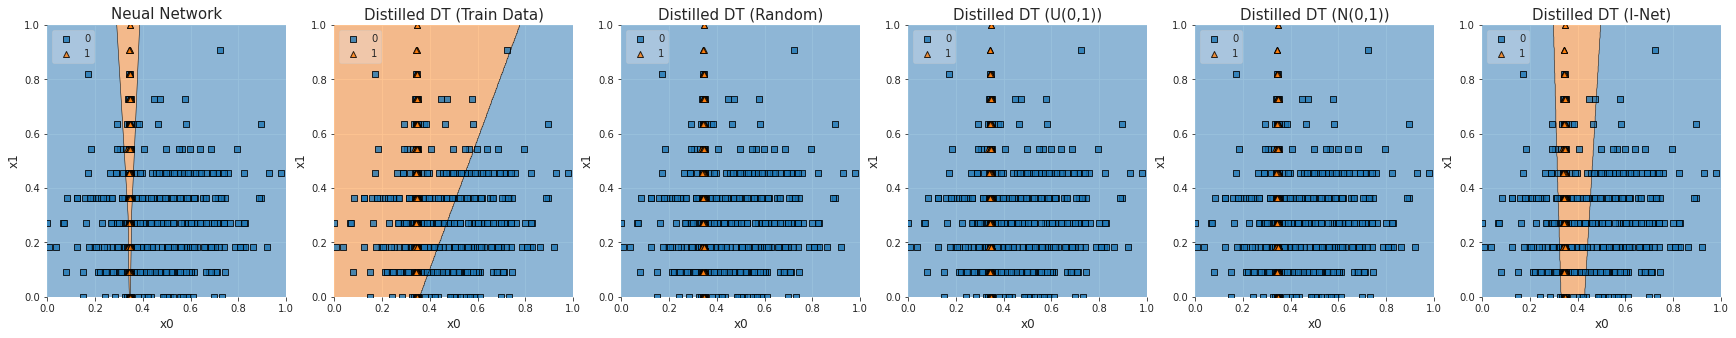

-----------------------------------------------------
Index:  85
Feature 1:  Samples 4459 / 541
	 Distribution 1: uniform
		 low: 1.013
		 high: 1.035
	 Distribution 2: uniform
		 low: 0.162
		 high: 3.767
Feature 2:  Samples 3911 / 1089
	 Distribution 1: beta
		 a: 1.608
		 b: 1.274
	 Distribution 2: beta
		 a: 2.447
		 b: 1.005
RESHAPE0
Considered Columns:								 0   1
Performance Network:								 0.628
Fidelity DT Sklearn Train Data:							 0.966
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.214
Fidelity DT Sklearn Uniform Data:						 0.214
Fidelity DT Sklearn Normal Data:						 0.214
Fidelity DT I-Net:								 0.912


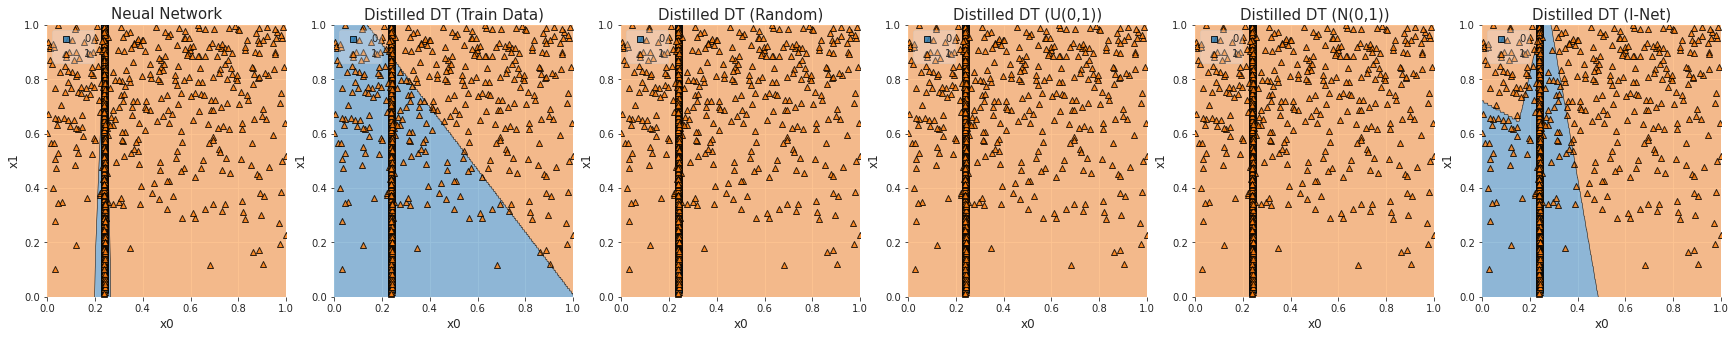

-----------------------------------------------------
Index:  664
Feature 1:  Samples 3039 / 1961
	 Distribution 1: poisson
		 lam: 0.006
	 Distribution 2: poisson
		 lam: 0.79
Feature 2:  Samples 3367 / 1633
	 Distribution 1: uniform
		 low: 1.074
		 high: 1.15
	 Distribution 2: uniform
		 low: 1.377
		 high: 3.188
RESHAPE0
Considered Columns:								 0   1
Performance Network:								 0.838
Fidelity DT Sklearn Train Data:							 1.0
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.316
Fidelity DT Sklearn Uniform Data:						 0.316
Fidelity DT Sklearn Normal Data:						 0.316
Fidelity DT I-Net:								 1.0


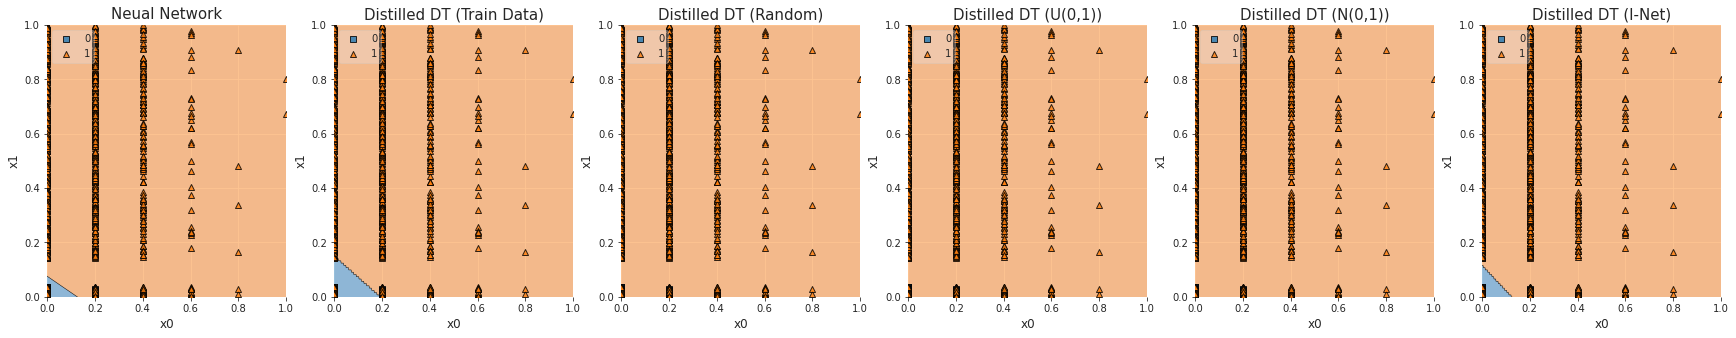

-----------------------------------------------------
Index:  644
Feature 1:  Samples 1230 / 3770
	 Distribution 1: gamma
		 shape: 2.627
		 scale: 2.338
	 Distribution 2: gamma
		 shape: 0.166
		 scale: 0.591
Feature 2:  Samples 4379 / 621
	 Distribution 1: normal
		 loc: 1.626
		 scale: 2.605
	 Distribution 2: normal
		 loc: 0.811
		 scale: 3.269
RESHAPE0
Considered Columns:								 0   1
Performance Network:								 0.736
Fidelity DT Sklearn Train Data:							 0.986
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.306
Fidelity DT Sklearn Uniform Data:						 0.306
Fidelity DT Sklearn Normal Data:						 0.306
Fidelity DT I-Net:								 0.96


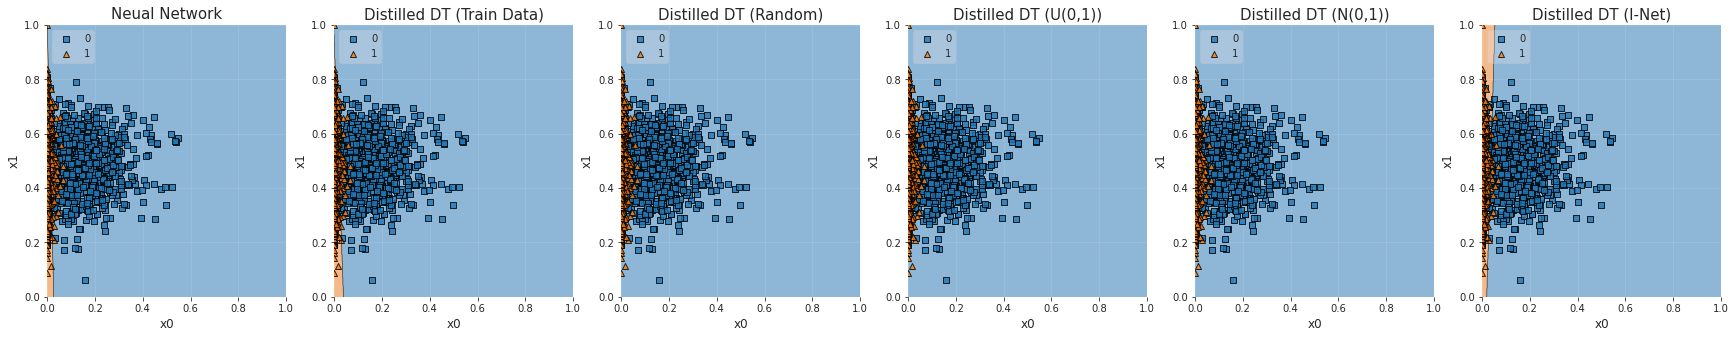

-----------------------------------------------------
Index:  859
Feature 1:  Samples 2692 / 2308
	 Distribution 1: uniform
		 low: 1.868
		 high: 2.826
	 Distribution 2: uniform
		 low: 1.662
		 high: 3.866
Feature 2:  Samples 4165 / 835
	 Distribution 1: uniform
		 low: 0.573
		 high: 0.598
	 Distribution 2: uniform
		 low: 0.445
		 high: 1.599
RESHAPE0
Considered Columns:								 0   1
Performance Network:								 0.808
Fidelity DT Sklearn Train Data:							 0.938
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.286
Fidelity DT Sklearn Uniform Data:						 0.286
Fidelity DT Sklearn Normal Data:						 0.286
Fidelity DT I-Net:								 0.914


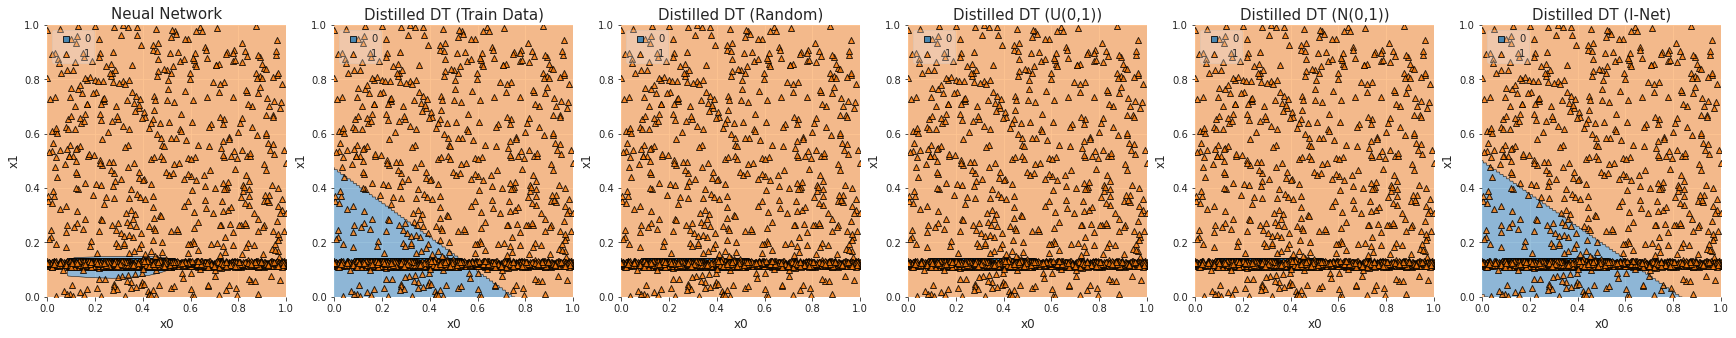

-----------------------------------------------------
Index:  599
Feature 1:  Samples 3972 / 1028
	 Distribution 1: uniform
		 low: 0.162
		 high: 2.712
	 Distribution 2: uniform
		 low: 0.39
		 high: 2.734
Feature 2:  Samples 1222 / 3778
	 Distribution 1: normal
		 loc: 3.368
		 scale: 4.278
	 Distribution 2: normal
		 loc: 1.169
		 scale: 0.138
RESHAPE0
Considered Columns:								 0   1
Performance Network:								 0.722
Fidelity DT Sklearn Train Data:							 0.814
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.276
Fidelity DT Sklearn Uniform Data:						 0.276
Fidelity DT Sklearn Normal Data:						 0.276
Fidelity DT I-Net:								 0.904


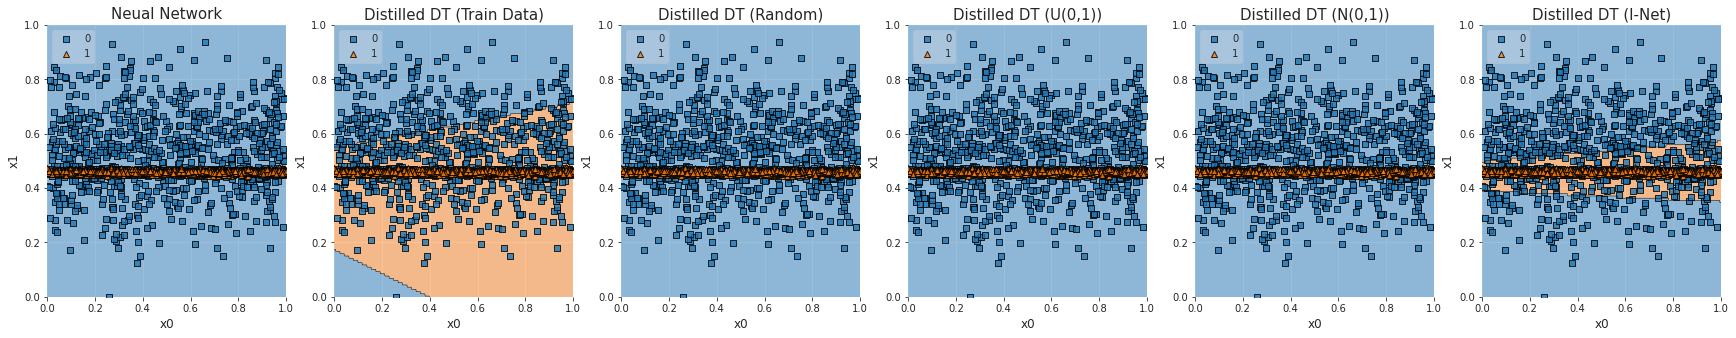

-----------------------------------------------------
Index:  126
Feature 1:  Samples 3943 / 1057
	 Distribution 1: gamma
		 shape: 2.761
		 scale: 0.431
	 Distribution 2: gamma
		 shape: 3.495
		 scale: 0.842
Feature 2:  Samples 3977 / 1023
	 Distribution 1: uniform
		 low: 2.56
		 high: 3.201
	 Distribution 2: uniform
		 low: 0.637
		 high: 4.832
RESHAPE0
Considered Columns:								 0   1
Performance Network:								 0.678
Fidelity DT Sklearn Train Data:							 0.972
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.168
Fidelity DT Sklearn Uniform Data:						 0.668
Fidelity DT Sklearn Normal Data:						 0.168
Fidelity DT I-Net:								 0.96


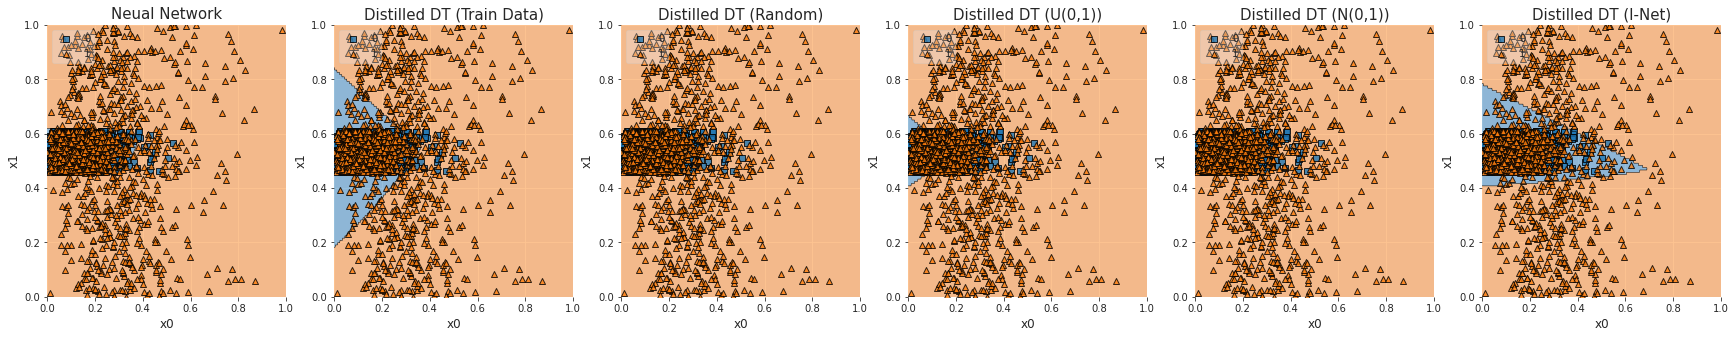

-----------------------------------------------------
Index:  873
Feature 1:  Samples 4466 / 534
	 Distribution 1: beta
		 a: 3.763
		 b: 0.758
	 Distribution 2: beta
		 a: 2.611
		 b: 2.118
Feature 2:  Samples 3372 / 1628
	 Distribution 1: normal
		 loc: 1.304
		 scale: 0.162
	 Distribution 2: normal
		 loc: 4.381
		 scale: 4.287
RESHAPE0
Considered Columns:								 0   1
Performance Network:								 0.798
Fidelity DT Sklearn Train Data:							 0.912
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.276
Fidelity DT Sklearn Uniform Data:						 0.276
Fidelity DT Sklearn Normal Data:						 0.276
Fidelity DT I-Net:								 0.896


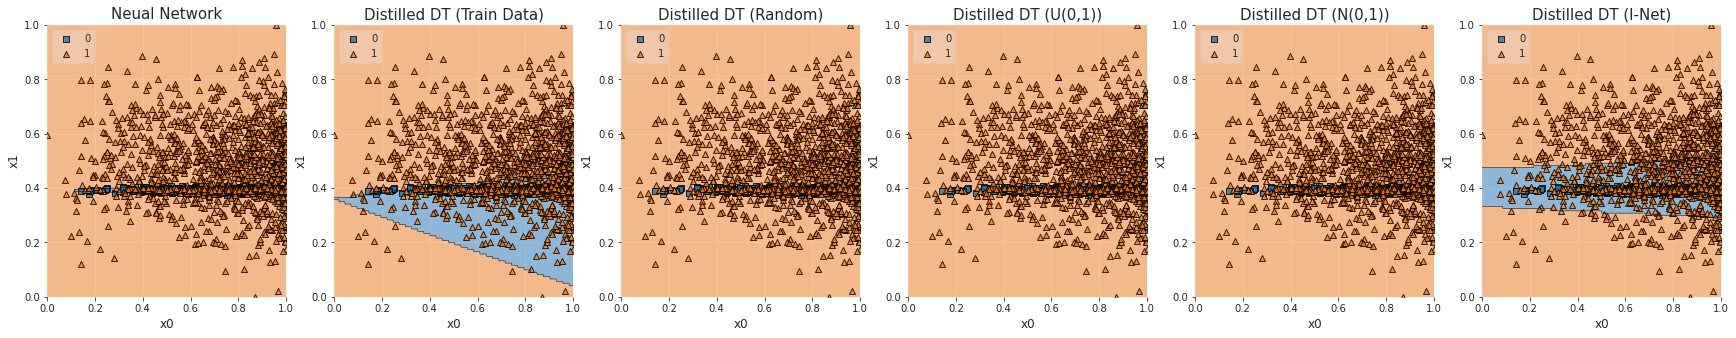

-----------------------------------------------------
Index:  276
Feature 1:  Samples 784 / 4216
	 Distribution 1: normal
		 loc: 0.273
		 scale: 3.27
	 Distribution 2: normal
		 loc: 0.438
		 scale: 4.621
Feature 2:  Samples 1069 / 3931
	 Distribution 1: uniform
		 low: 2.188
		 high: 3.451
	 Distribution 2: uniform
		 low: 2.921
		 high: 2.993
RESHAPE0
Considered Columns:								 0   1
Performance Network:								 0.704
Fidelity DT Sklearn Train Data:							 0.93
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.23
Fidelity DT Sklearn Uniform Data:						 0.23
Fidelity DT Sklearn Normal Data:						 0.23
Fidelity DT I-Net:								 0.85


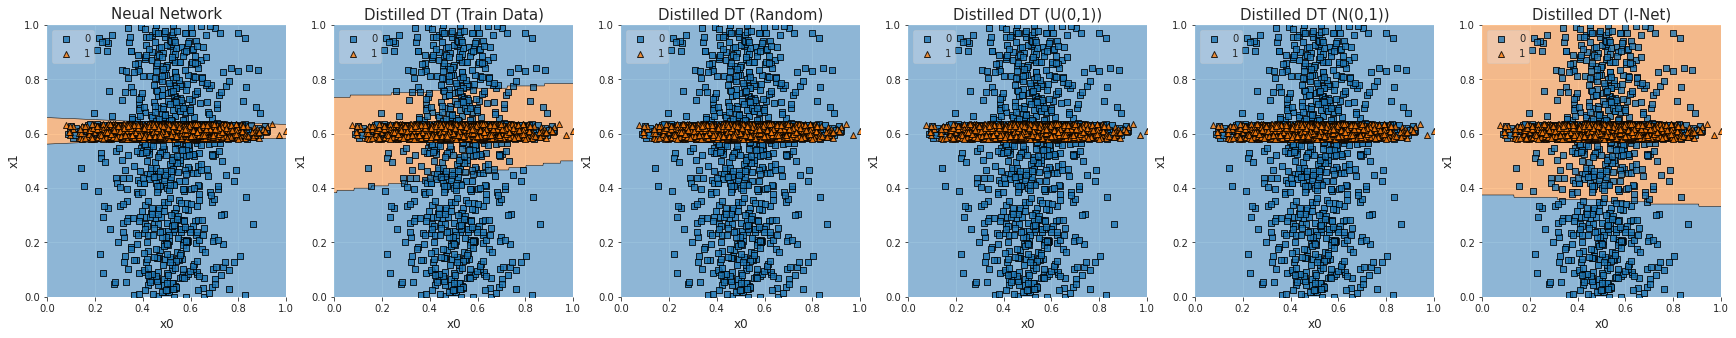

-----------------------------------------------------
Index:  619
Feature 1:  Samples 1789 / 3211
	 Distribution 1: gamma
		 shape: 3.828
		 scale: 3.897
	 Distribution 2: gamma
		 shape: 0.944
		 scale: 0.039
Feature 2:  Samples 920 / 4080
	 Distribution 1: beta
		 a: 3.337
		 b: 4.999
	 Distribution 2: beta
		 a: 3.009
		 b: 0.449
RESHAPE0
Considered Columns:								 0   1
Performance Network:								 0.866
Fidelity DT Sklearn Train Data:							 0.998
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.392
Fidelity DT Sklearn Uniform Data:						 0.392
Fidelity DT Sklearn Normal Data:						 0.392
Fidelity DT I-Net:								 0.998


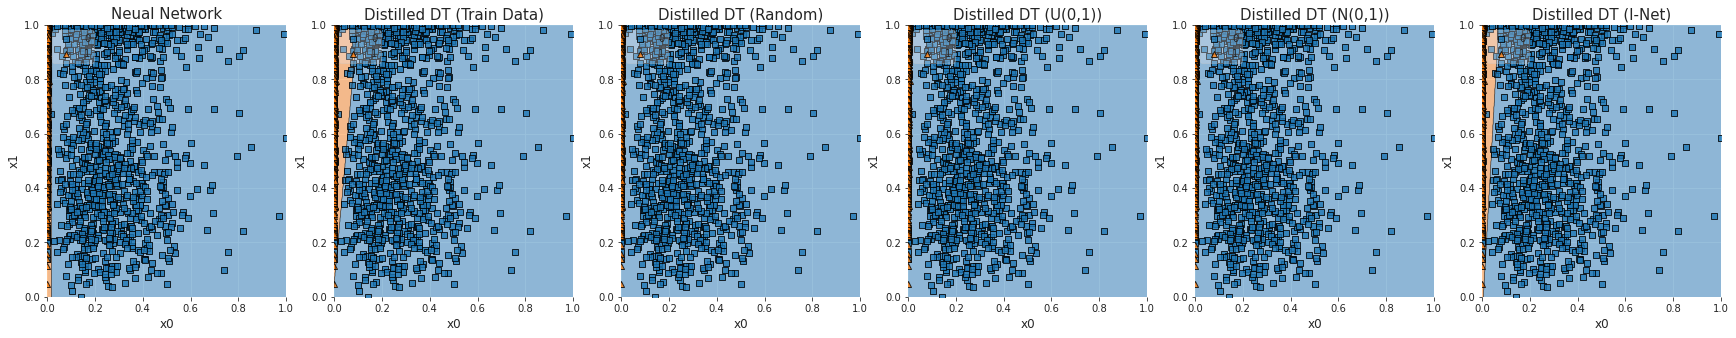

-----------------------------------------------------
Index:  341
Feature 1:  Samples 4900 / 100
	 Distribution 1: gamma
		 shape: 4.671
		 scale: 1.605
	 Distribution 2: gamma
		 shape: 0.03
		 scale: 0.576
Feature 2:  Samples 646 / 4354
	 Distribution 1: normal
		 loc: 1.604
		 scale: 4.251
	 Distribution 2: normal
		 loc: 4.764
		 scale: 0.398
RESHAPE0
Considered Columns:								 0   1
Performance Network:								 0.602
Fidelity DT Sklearn Train Data:							 0.906
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.176
Fidelity DT Sklearn Uniform Data:						 0.176
Fidelity DT Sklearn Normal Data:						 0.176
Fidelity DT I-Net:								 0.78


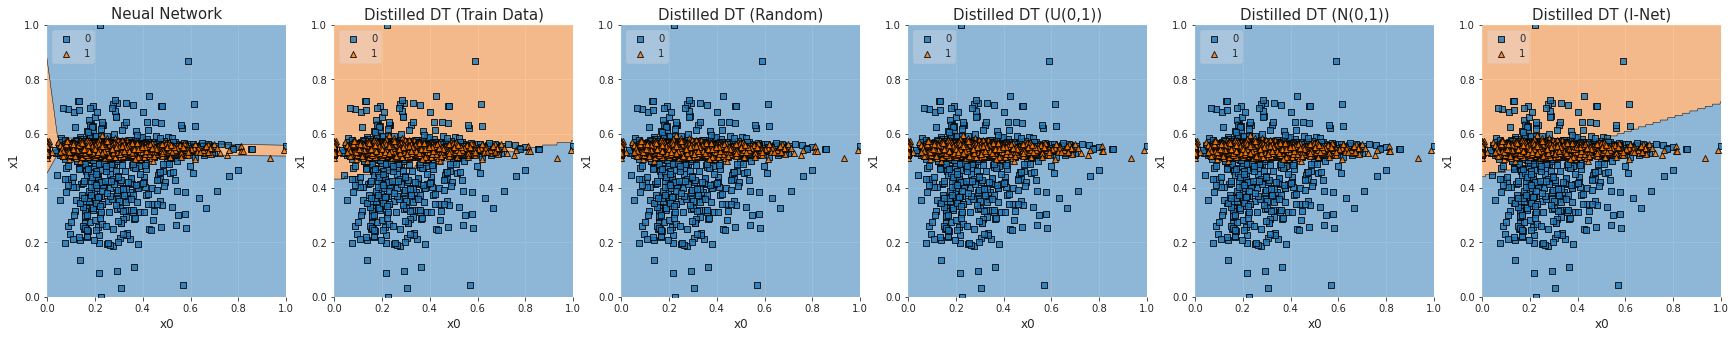

-----------------------------------------------------
Index:  669
Feature 1:  Samples 4266 / 734
	 Distribution 1: uniform
		 low: 0.114
		 high: 0.284
	 Distribution 2: uniform
		 low: 1.855
		 high: 4.501
Feature 2:  Samples 1664 / 3336
	 Distribution 1: normal
		 loc: 0.604
		 scale: 3.025
	 Distribution 2: normal
		 loc: 1.002
		 scale: 2.689
RESHAPE0
Considered Columns:								 0   1
Performance Network:								 0.646
Fidelity DT Sklearn Train Data:							 1.0
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.12
Fidelity DT Sklearn Uniform Data:						 1.0
Fidelity DT Sklearn Normal Data:						 0.12
Fidelity DT I-Net:								 1.0


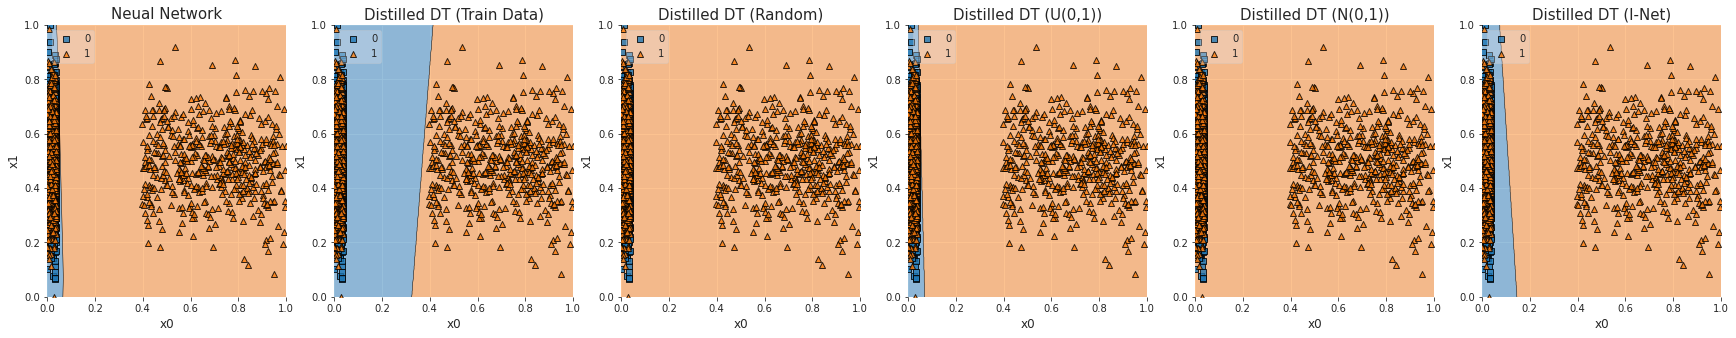

-----------------------------------------------------
Index:  923
Feature 1:  Samples 2770 / 2230
	 Distribution 1: gamma
		 shape: 0.178
		 scale: 0.009
	 Distribution 2: gamma
		 shape: 4.746
		 scale: 2.596
Feature 2:  Samples 2784 / 2216
	 Distribution 1: poisson
		 lam: 0.09
	 Distribution 2: poisson
		 lam: 1.808
RESHAPE0
Considered Columns:								 0   1
Performance Network:								 0.946
Fidelity DT Sklearn Train Data:							 0.998
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.42
Fidelity DT Sklearn Uniform Data:						 0.42
Fidelity DT Sklearn Normal Data:						 0.42
Fidelity DT I-Net:								 1.0


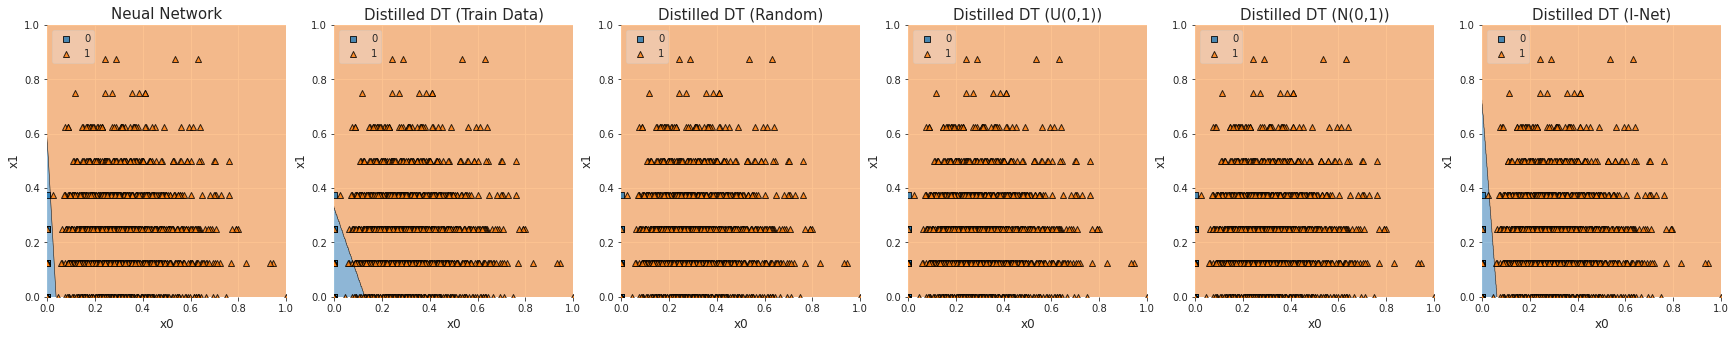

-----------------------------------------------------
Index:  901
Feature 1:  Samples 646 / 4354
	 Distribution 1: gamma
		 shape: 4.161
		 scale: 4.771
	 Distribution 2: gamma
		 shape: 0.202
		 scale: 1.029
Feature 2:  Samples 3108 / 1892
	 Distribution 1: poisson
		 lam: 3.51
	 Distribution 2: poisson
		 lam: 2.408
RESHAPE0
Considered Columns:								 0   1
Performance Network:								 0.692
Fidelity DT Sklearn Train Data:							 0.992
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.342
Fidelity DT Sklearn Uniform Data:						 0.342
Fidelity DT Sklearn Normal Data:						 0.342
Fidelity DT I-Net:								 0.922


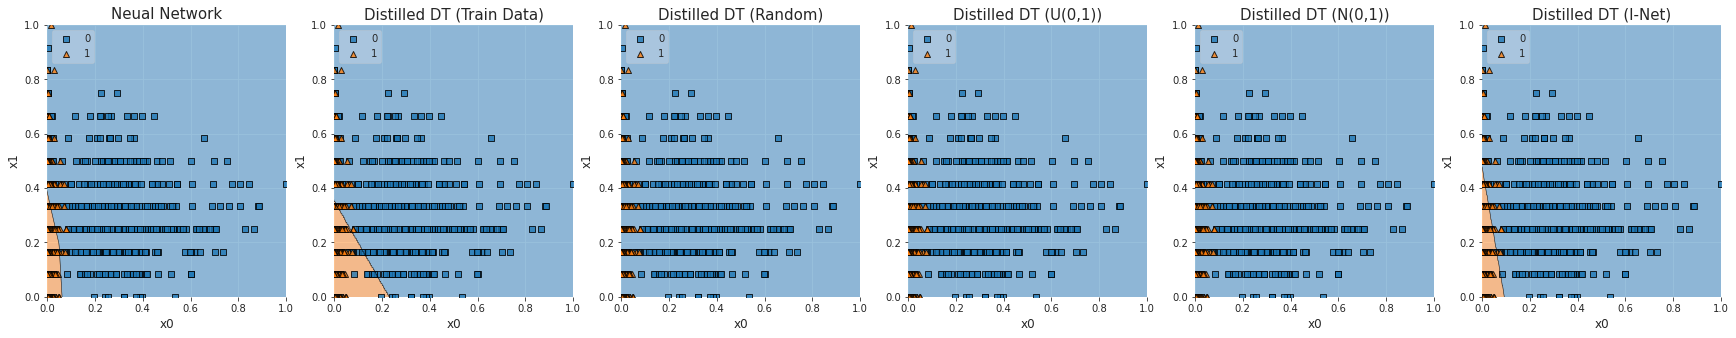

-----------------------------------------------------
Index:  241
Feature 1:  Samples 4525 / 475
	 Distribution 1: gamma
		 shape: 1.684
		 scale: 0.537
	 Distribution 2: gamma
		 shape: 1.747
		 scale: 4.77
Feature 2:  Samples 4918 / 82
	 Distribution 1: uniform
		 low: 2.617
		 high: 3.706
	 Distribution 2: uniform
		 low: 1.64
		 high: 4.514
RESHAPE0
Considered Columns:								 0   1
Performance Network:								 0.568
Fidelity DT Sklearn Train Data:							 0.984
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.126
Fidelity DT Sklearn Uniform Data:						 0.994
Fidelity DT Sklearn Normal Data:						 0.126
Fidelity DT I-Net:								 0.988


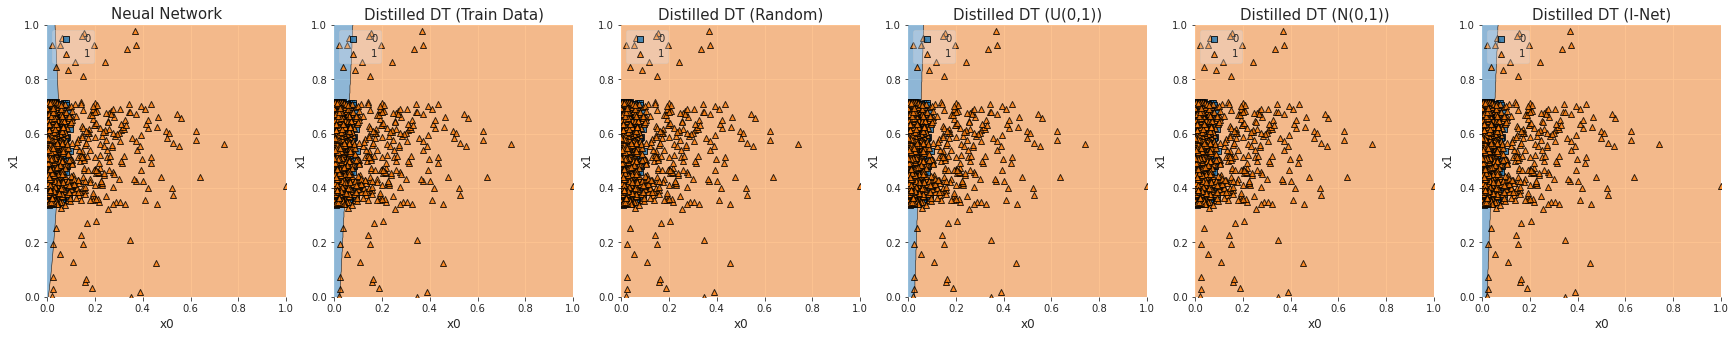

-----------------------------------------------------
Index:  704
Feature 1:  Samples 4592 / 408
	 Distribution 1: uniform
		 low: 3.116
		 high: 4.55
	 Distribution 2: uniform
		 low: 0.347
		 high: 3.111
Feature 2:  Samples 3924 / 1076
	 Distribution 1: uniform
		 low: 3.439
		 high: 3.52
	 Distribution 2: uniform
		 low: 2.355
		 high: 3.278
RESHAPE0
Considered Columns:								 0   1
Performance Network:								 0.71
Fidelity DT Sklearn Train Data:							 0.994
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.184
Fidelity DT Sklearn Uniform Data:						 0.924
Fidelity DT Sklearn Normal Data:						 0.184
Fidelity DT I-Net:								 1.0


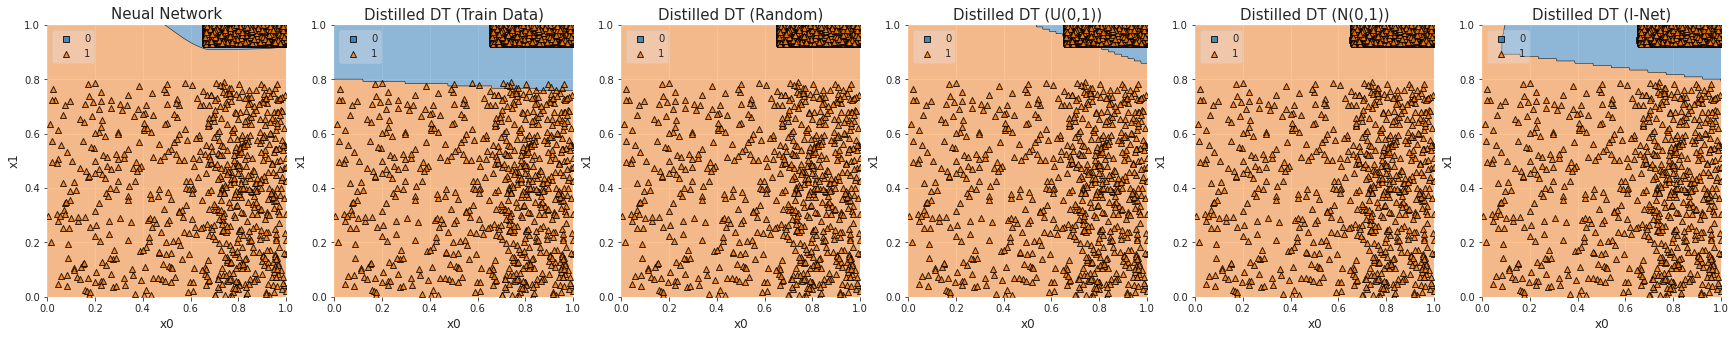

-----------------------------------------------------
Index:  472
Feature 1:  Samples 4371 / 629
	 Distribution 1: beta
		 a: 0.032
		 b: 4.69
	 Distribution 2: beta
		 a: 2.523
		 b: 0.514
Feature 2:  Samples 4636 / 364
	 Distribution 1: uniform
		 low: 1.235
		 high: 4.057
	 Distribution 2: uniform
		 low: 0.608
		 high: 4.385
RESHAPE0
Considered Columns:								 0   1
Performance Network:								 0.65
Fidelity DT Sklearn Train Data:							 0.986
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.144
Fidelity DT Sklearn Uniform Data:						 1.0
Fidelity DT Sklearn Normal Data:						 0.144
Fidelity DT I-Net:								 0.998


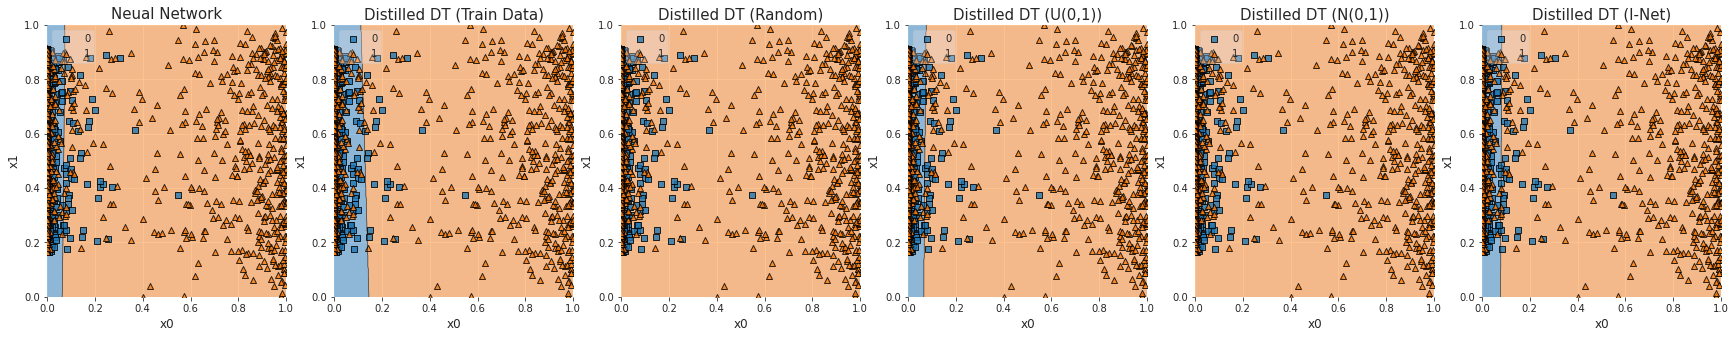

-----------------------------------------------------
Index:  532
Feature 1:  Samples 1623 / 3377
	 Distribution 1: beta
		 a: 0.932
		 b: 2.989
	 Distribution 2: beta
		 a: 0.06
		 b: 3.827
Feature 2:  Samples 528 / 4472
	 Distribution 1: gamma
		 shape: 2.677
		 scale: 4.365
	 Distribution 2: gamma
		 shape: 1.51
		 scale: 0.391
RESHAPE0
Considered Columns:								 0   1
Performance Network:								 0.77
Fidelity DT Sklearn Train Data:							 0.974
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.404
Fidelity DT Sklearn Uniform Data:						 0.404
Fidelity DT Sklearn Normal Data:						 0.404
Fidelity DT I-Net:								 0.97


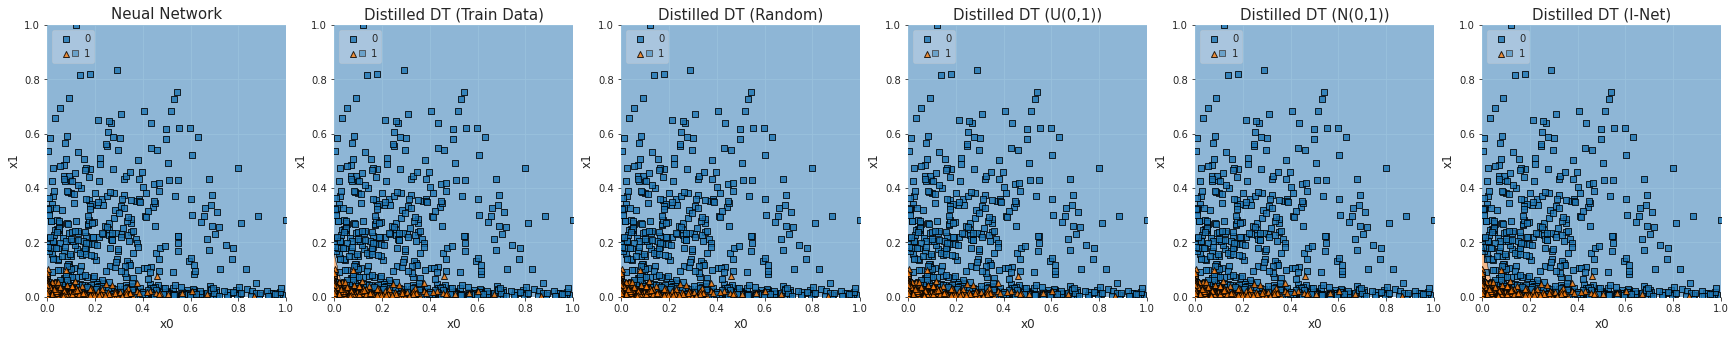

-----------------------------------------------------
Index:  396
Feature 1:  Samples 4753 / 247
	 Distribution 1: poisson
		 lam: 0.942
	 Distribution 2: poisson
		 lam: 3.833
Feature 2:  Samples 3636 / 1364
	 Distribution 1: poisson
		 lam: 0.017
	 Distribution 2: poisson
		 lam: 2.215
RESHAPE0
Considered Columns:								 0   1
Performance Network:								 0.74
Fidelity DT Sklearn Train Data:							 1.0
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.836
Fidelity DT Sklearn Uniform Data:						 0.234
Fidelity DT Sklearn Normal Data:						 0.234
Fidelity DT I-Net:								 1.0


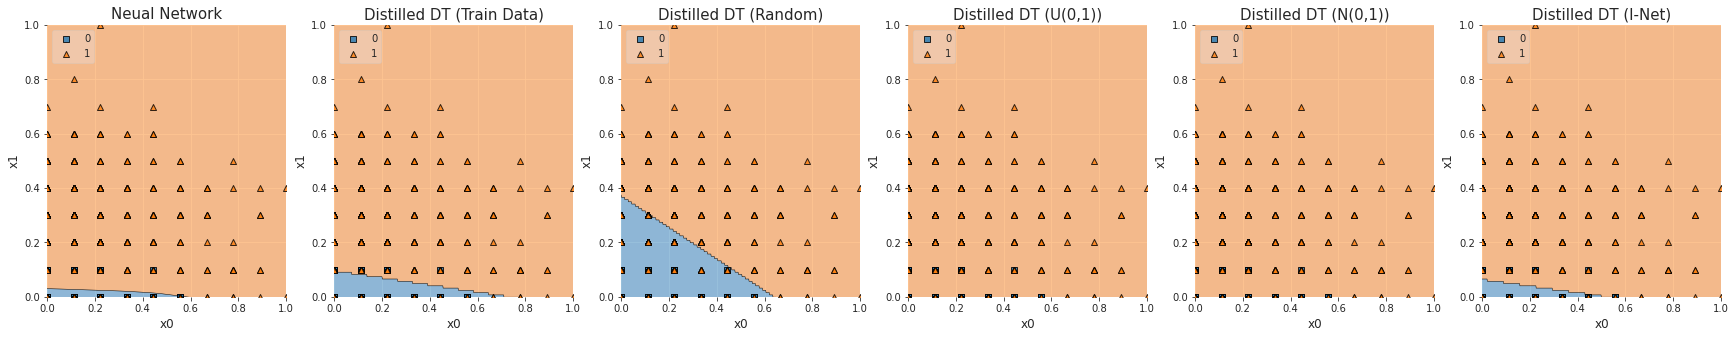

-----------------------------------------------------
Index:  829
Feature 1:  Samples 1491 / 3509
	 Distribution 1: uniform
		 low: 2.291
		 high: 4.851
	 Distribution 2: uniform
		 low: 3.705
		 high: 3.718
Feature 2:  Samples 2439 / 2561
	 Distribution 1: poisson
		 lam: 3.635
	 Distribution 2: poisson
		 lam: 3.349
RESHAPE0
Considered Columns:								 0   1
Performance Network:								 0.796
Fidelity DT Sklearn Train Data:							 0.94
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.322
Fidelity DT Sklearn Uniform Data:						 0.322
Fidelity DT Sklearn Normal Data:						 0.322
Fidelity DT I-Net:								 0.87


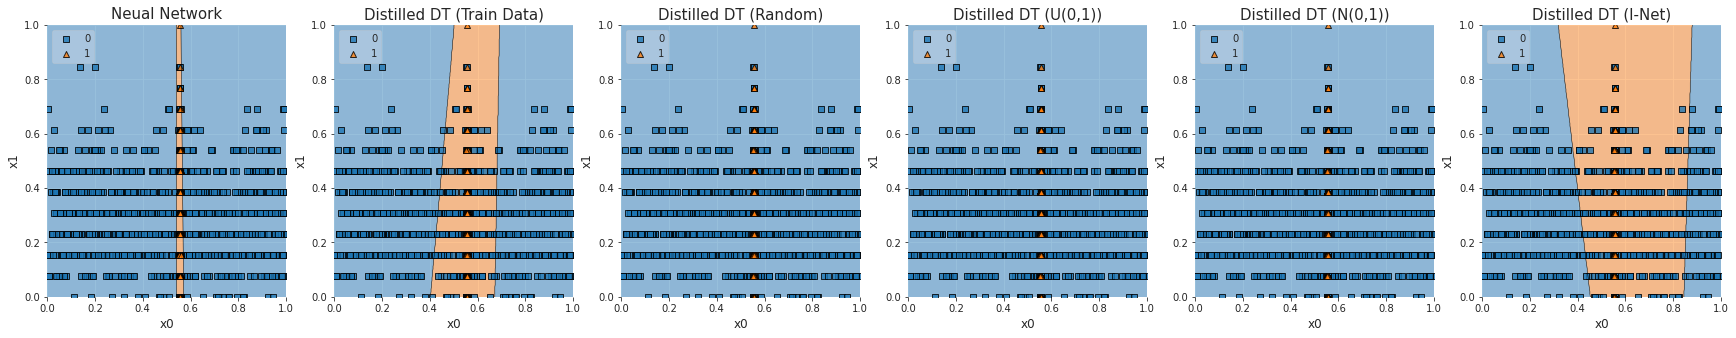

-----------------------------------------------------
Index:  695
Feature 1:  Samples 2195 / 2805
	 Distribution 1: gamma
		 shape: 3.935
		 scale: 2.831
	 Distribution 2: gamma
		 shape: 3.29
		 scale: 0.003
Feature 2:  Samples 1101 / 3899
	 Distribution 1: beta
		 a: 0.562
		 b: 0.709
	 Distribution 2: beta
		 a: 1.858
		 b: 1.833
RESHAPE0
Considered Columns:								 0   1
Performance Network:								 0.936
Fidelity DT Sklearn Train Data:							 0.998
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.462
Fidelity DT Sklearn Uniform Data:						 0.462
Fidelity DT Sklearn Normal Data:						 0.462
Fidelity DT I-Net:								 1.0


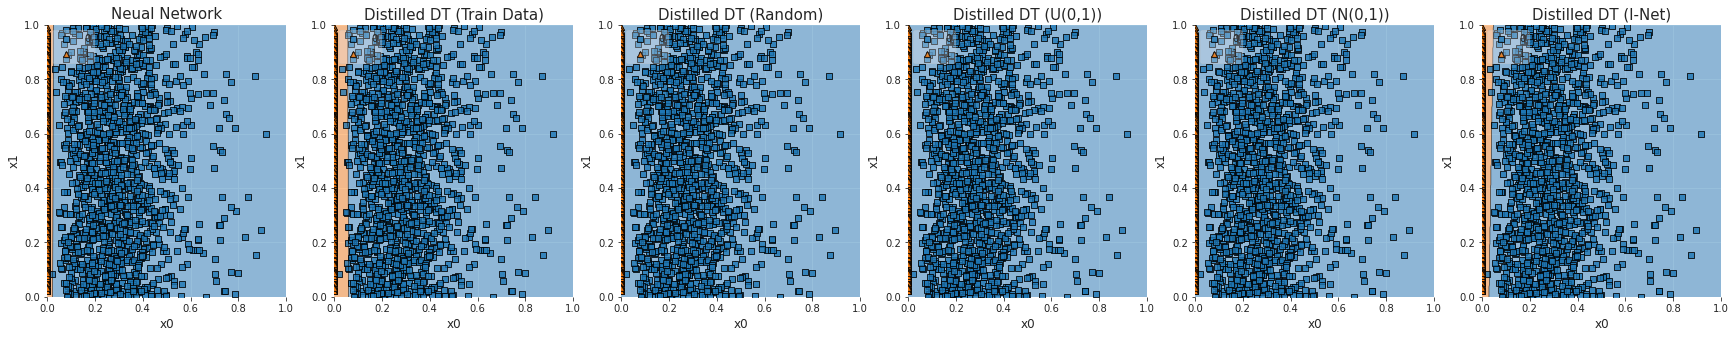

-----------------------------------------------------
Index:  351
Feature 1:  Samples 4163 / 837
	 Distribution 1: gamma
		 shape: 4.422
		 scale: 1.031
	 Distribution 2: gamma
		 shape: 3.331
		 scale: 4.637
Feature 2:  Samples 4662 / 338
	 Distribution 1: gamma
		 shape: 0.305
		 scale: 2.484
	 Distribution 2: gamma
		 shape: 0.101
		 scale: 4.095
RESHAPE0
Considered Columns:								 0   1
Performance Network:								 0.634
Fidelity DT Sklearn Train Data:							 0.97
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.18
Fidelity DT Sklearn Uniform Data:						 0.936
Fidelity DT Sklearn Normal Data:						 0.18
Fidelity DT I-Net:								 0.958


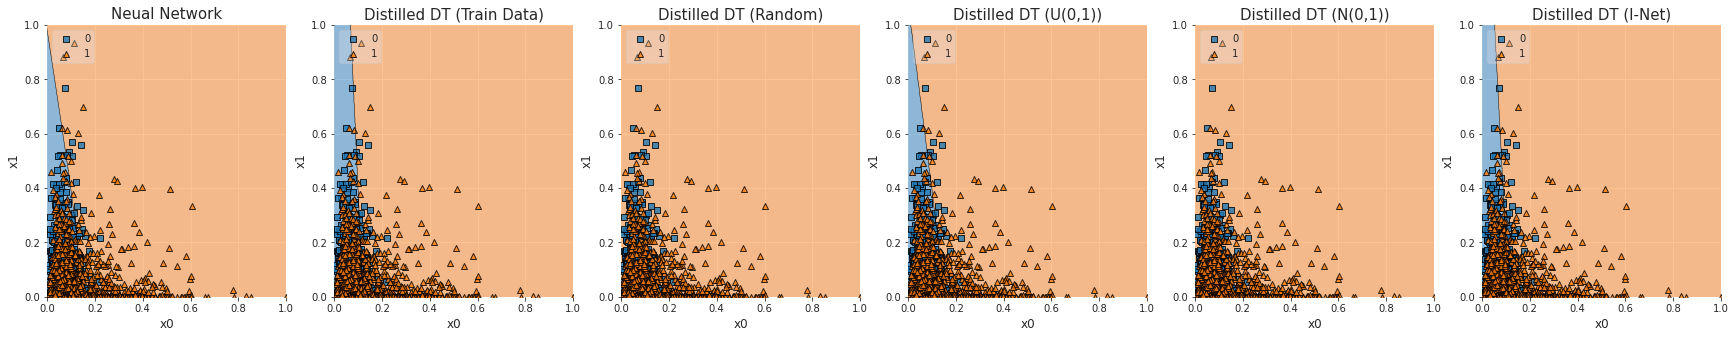

-----------------------------------------------------


In [31]:
if evaluate_distribution:
    timestr = time.strftime("%Y%m%d-%H%M%S")
    identifier_folder = config['function_family']['dt_type'] + '_' + str(config['function_family']['decision_sparsity']) + '_' + timestr
    os.makedirs('./data/distrib_plots/' + identifier_folder + '/', exist_ok=True)
    
    for i in range(min(25, test_size)):
        #index = 14
        #index = np.argmax(np.array(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['inet_scores']['accuracy']) - np.array(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['dt_scores']['accuracy']))
        top_number = i
        #index = np.argsort(np.array(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['inet_scores']['accuracy']) - np.array(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['dt_scores']['accuracy']))[::-1][top_number]

        scores_distilled_median_random = np.median(np.array([inet_evaluation_result_dict_complete_by_distribution_test[str(distrib)]['dt_scores']['accuracy'] for distrib in config['data']['distribution_list_eval']]), axis=0)
        scores_distilled_uniform = inet_evaluation_result_dict_complete_by_distribution_test[str(config['data']['distribution_list_eval'][0])]['dt_scores']['accuracy_uniform_data']
        scores_distilled_normal = inet_evaluation_result_dict_complete_by_distribution_test[str(config['data']['distribution_list_eval'][0])]['dt_scores']['accuracy_normal_data']
        
        scores_distilled_array = np.mean([scores_distilled_median_random, scores_distilled_uniform, scores_distilled_normal], axis=0)
        
        index = np.argsort(np.array(inet_evaluation_result_dict_complete_by_distribution_test[list(inet_evaluation_result_dict_complete_by_distribution_test.keys())[0]]['inet_scores']['accuracy']) - scores_distilled_array)[::-1][top_number]
        #index = np.argsort(np.array(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['inet_scores']['accuracy']) - np.max(np.array([inet_evaluation_result_dict_complete_by_distribution_test[distrib]['dt_scores']['accuracy'] for distrib in config['data']['distribution_list_eval']]), axis=0))[::-1][top_number]
        #index = np.argsort(np.array(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['inet_scores']['accuracy']) - np.mean(np.array([inet_evaluation_result_dict_complete_by_distribution_test[distrib]['dt_scores']['accuracy'] for distrib in config['data']['distribution_list_eval']]), axis=0))[::-1][top_number]

        distrib_for_index = np.argmax(np.array([inet_evaluation_result_dict_complete_by_distribution_test[str(distrib)]['dt_scores']['accuracy'] for distrib in config['data']['distribution_list_eval']])[:,index])

        print('Index: ', index)
        distribution_dict = distribution_parameter_list_list[index]

        print('Feature 1: ', 'Samples', distribution_dict[0][list(distribution_dict[0].keys())[0]]['samples_class_0'], '/', config['data']['lambda_dataset_size']-distribution_dict[0][list(distribution_dict[0].keys())[0]]['samples_class_0'])
        print('\t Distribution 1: ' + list(distribution_dict[0].keys())[0])
        for j, (distrib_parameter_name, distrib_parameter_value) in enumerate(distribution_dict[0][list(distribution_dict[0].keys())[0]]['class_0'].items()):
            print('\t\t '  + distrib_parameter_name +  ': ' + str(np.round(distrib_parameter_value, 3)))
        print('\t Distribution 2: ' + list(distribution_dict[0].keys())[0])
        for j, (distrib_parameter_name, distrib_parameter_value) in enumerate(distribution_dict[0][list(distribution_dict[0].keys())[0]]['class_1'].items()):
            print('\t\t '  + distrib_parameter_name +  ': ' + str(np.round(distrib_parameter_value, 3)))

        print('Feature 2: ', 'Samples', distribution_dict[1][list(distribution_dict[1].keys())[0]]['samples_class_0'], '/', config['data']['lambda_dataset_size']-distribution_dict[1][list(distribution_dict[1].keys())[0]]['samples_class_0'])
        print('\t Distribution 1: ' + list(distribution_dict[1].keys())[0])
        for j, (distrib_parameter_name, distrib_parameter_value) in enumerate(distribution_dict[1][list(distribution_dict[1].keys())[0]]['class_0'].items()):
            print('\t\t '  + distrib_parameter_name +  ': ' + str(np.round(distrib_parameter_value, 3)))
        print('\t Distribution 2: ' + list(distribution_dict[1].keys())[0])
        for j, (distrib_parameter_name, distrib_parameter_value) in enumerate(distribution_dict[1][list(distribution_dict[1].keys())[0]]['class_1'].items()):
            print('\t\t '  + distrib_parameter_name +  ': ' + str(np.round(distrib_parameter_value, 3)))

        identifier_file = 'index' + str(index) + '_' + '_'.join([list(dist.keys())[0] + '_' +  '_'.join([key + '-' + str(np.round(value, 4)) for key, value in dist[list(dist.keys())[0]]['class_0'].items()]) + '_' + '_'.join([key + '-' + str(np.round(value, 4)) for key, value in dist[list(dist.keys())[0]]['class_1'].items()]) for dist in distribution_parameter_list_list[index]])
        
        plot_decision_area_evaluation_all_distrib(data_dict_list_test[index]['X_train'], 
                                            data_dict_list_test[index]['y_train'], 
                                            data_dict_list_test[index]['X_test'], 
                                            data_dict_list_test[index]['y_test'],
                                            None,
                                            None,
                                            network_parameters_to_network(shaped_network_parameters_to_array(test_network_list_distrib[index], config), config),
                                            dt_distilled_list_test[0][index][-3],
                                            dt_distilled_list_test[0][index][-2],
                                            dt_distilled_list_test[0][index][-1],
                                            [dt_distilled_list_test[i][index][0] for i in range(len(config['data']['distribution_list_eval']))],     
                                            dt_inet_list_test[0][index],
                                            np.array([str(i) for i in range(data_dict_list_test[index]['X_train'].shape[1])]),
                                            config['data']['distribution_list_eval'],
                                            config,
                                            identifier_folder = identifier_folder,
                                            identifier_file = identifier_file
                                           )    



In [ ]:
if config['function_family']['dt_type'] == 'vanilla':
    print('I-Net Decision Tree')
    plt.figure(figsize=(15,8))
    dt_inet = parameterDT(dt_inet_list_test[distrib_for_index][index], config)
    image = dt_inet.plot()
    display(image)
    
    print('Random Data Decision Tree')
    plt.figure(figsize=(15,8))
    plot_tree(dt_distilled_list_test[distrib_for_index][index][0], fontsize=10)  #fist index=distrib; second index=index; third index=[config['evaluation']['random_evaluation_dataset_size_per_distribution'], 'TRAINDATA', 'STANDARDUNIFORM', 'STANDARDNORMAL']
    plt.show()
    
    print('Train Data Decision Tree')
    plt.figure(figsize=(15,8))
    plot_tree(dt_distilled_list_test[distrib_for_index][index][1], fontsize=10)  #fist index=distrib; second index=index; third index=[config['evaluation']['random_evaluation_dataset_size_per_distribution'], 'TRAINDATA', 'STANDARDUNIFORM', 'STANDARDNORMAL']
    plt.show()    
    
    print('Uniform Data Decision Tree')
    plt.figure(figsize=(15,8))
    plot_tree(dt_distilled_list_test[distrib_for_index][index][2], fontsize=10)  #fist index=distrib; second index=index; third index=[config['evaluation']['random_evaluation_dataset_size_per_distribution'], 'TRAINDATA', 'STANDARDUNIFORM', 'STANDARDNORMAL']
    plt.show()    
else:
    print('I-Net Decision Tree')
    plt.figure(figsize=(15,8))
    dt_parameters = dt_inet_list_test[distrib_for_index][index]
    tree = generate_random_decision_tree(config)
    tree.initialize_from_parameter_array(dt_parameters, reshape=True, config=config)
    image = tree.plot_tree()
    display(image)
    
    print('Random Data Decision Tree')
    plt.figure(figsize=(15,8))
    image = dt_distilled_list_test[distrib_for_index][index][0].plot_tree() #fist index=distrib; second index=index; third index=[config['evaluation']['random_evaluation_dataset_size_per_distribution'], 'TRAINDATA', 'STANDARDUNIFORM', 'STANDARDNORMAL']
    display(image)
    
    print('Train Data Decision Tree')
    plt.figure(figsize=(15,8)) 
    image = dt_distilled_list_test[distrib_for_index][index][1].plot_tree() #fist index=distrib; second index=index; third index=[config['evaluation']['random_evaluation_dataset_size_per_distribution'], 'TRAINDATA', 'STANDARDUNIFORM', 'STANDARDNORMAL'] 
    display(image)
    
    print('Uniform Data Decision Tree')
    plt.figure(figsize=(15,8))
    image = dt_distilled_list_test[distrib_for_index][index][2].plot_tree() #fist index=distrib; second index=index; third index=[config['evaluation']['random_evaluation_dataset_size_per_distribution'], 'TRAINDATA', 'STANDARDUNIFORM', 'STANDARDNORMAL']
    display(image)

In [ ]:
if False:
    plot_class_distrib_by_feature(model = model,
                                  index = index,
                                  test_network = network_parameters_to_network(lambda_net_dataset_valid.network_parameters_array[index], config, base_model=None),
                                  distribution_training = config['data']['distribution_list_eval'][distrib_for_index],
                                  distribution_dict = lambda_net_dataset_valid.distribution_dict_list_list[index],
                                  X_test = lambda_net_dataset_valid.X_test_lambda_array[index],
                                  config = config)

In [ ]:
if False:
    plot_class_distrib_by_feature(model = model,
                                  index = index,
                                  test_network = network_parameters_to_network(shaped_network_parameters_to_array(test_network_list_distrib[index], config), config, base_model=None),
                                  distribution_training = config['data']['distribution_list_eval'][distrib_for_index],
                                  distribution_dict = lambda_net_dataset_valid.distribution_dict_list_list[index],
                                  X_test =  data_dict_list_test[0]['X_test'],
                                  config = config)

### Distribution Evaluation (Selected Samples)

In [ ]:
#%load_ext autoreload
#%autoreload 2
if False:
    evaluate_network_on_distribution_custom_parameters(distribution_name_feature_0 = 'normal',
                                                       distribution_name_feature_1 = 'normal',
                                                       distribution_parameters_0_param_1_feature_0 = 1.188840288782265,
                                                       distribution_parameters_0_param_2_feature_0 = 0.8566173698593895,
                                                       distribution_parameters_1_param_1_feature_0 = 0.8713650102755661,
                                                       distribution_parameters_1_param_2_feature_0 = 1.8484540179178748,
                                                       distribution_parameters_0_param_1_feature_1 = 1.7185974826882278,
                                                       distribution_parameters_0_param_2_feature_1 = 0.5807878500034862,
                                                       distribution_parameters_1_param_1_feature_1 = 0.44369536008631294,
                                                       distribution_parameters_1_param_2_feature_1 = 1.17864258666672,
                                                       inet = model,
                                                       config = config,
                                                       distribution_list_evaluation = config['data']['distribution_list_eval'])


In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()